# Carbon Regression
We want to predict the Carbon Emissions of a car based on various information such as Make, Model, and Fuel Consumption.

![CO2 Emissions Cover Image generated using Microsoft Designer AI](../images/co2-cover-image.jpeg)

# 1. Setup and Imports

## 1.1 Import Libraries

In [1]:
import sys, os
import requests
import numpy as np
import pandas as pd

# Visualization libraries
from pyfonts import load_font
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = 12,8
palette = sns.color_palette("viridis", as_cmap=True)
sns.set_palette("viridis")

# Modeling libraries
import scipy as sp
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import set_config

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

import mlflow

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(mpl.__version__))
print("SciPy version: {}". format(sp.__version__)) 
print("scikit-learn version: {}". format(sklearn.__version__))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# print(check_output(["ls", "../input/co2-emission-by-vehicles"]).decode("utf8"))

Python version: 3.12.10 (main, Apr 17 2025, 03:50:21) [Clang 17.0.0 (clang-1700.0.13.3)]
NumPy version: 2.2.5
pandas version: 2.2.3
matplotlib version: 3.10.1
SciPy version: 1.15.2
scikit-learn version: 1.6.1
-------------------------


In [2]:
# Enable MLflow's automatic experiment tracking for scikit-learn
mlflow.sklearn.autolog()

In [3]:
FONT_URL = "https://github.com/google/fonts/blob/0e70abe31055681b7744b8ea67f579ecda97fc0b/ofl/robotomono/RobotoMono%5Bwght%5D.ttf?raw=true"
new_default_font = load_font(
    font_url=FONT_URL,
)
mpl.font_manager.fontManager.addfont(new_default_font._file)
family = new_default_font.get_family()[0]
plt.rcParams['font.family'] = family
plt.rcParams['font.{}'.format(family)] = new_default_font.get_name()

## 1.2 Load Data

In [4]:
DATA_FOLDER = '../data'
# DATA_FILE_PATH = "/kaggle/input/co2-emission-by-vehicles/CO2 Emissions_Canada.csv"
DATA_FILE_PATH = os.path.join(DATA_FOLDER, "co2-emission-by-vehicles/CO2 Emissions_Canada.csv")

In [5]:
df = pd.read_csv(DATA_FILE_PATH)
df.head()

Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           33                  196  
1                           29                  221  
2                           48                  136  
3                           25                  255  
4                           27                  244

In [6]:
# Global variables
RANDOM_STATE = 42

COLUMNS = df.columns.tolist()
LABEL = ['CO2 Emissions(g/km)']
NUMERICAL_FEATURES = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)']
CATEGORICAL_FEATURES = ['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type']
FEATURES_TO_SCALE = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)']
REMAINDER_FEATURES = [feature for feature in COLUMNS if feature not in FEATURES_TO_SCALE]

# 2. EDA (Exploratory Data Analysis)

## 2.1 Data Overview
Let's check the columns, data types, counts etc.

### Domain Knowledge & Critical Thinking

Predicting CO2 emissions of ICE is important, but so is understanding CO2 emissions of Electric vehicles.

Electric vehicles are not included in this dataset for obvious reasons, but that does not mean they do not contribute to C02 emissions and other environmental pollution.

https://afdc.energy.gov/vehicles/electric-emissions

Mining rare-earth minerals for EVs results in massive amounts of carbon emissions, and also pollutes the environment in other terrible ways.

Manufacturing of a vehicle itself is a huge proportion of total carbon emissions, and it is even likely that EVs are worse for the environment unless battery technology is improved.

Building the 80kWh battery found in the Tesla Model 3 for example produces around 80% more emissions than building a comparable gasoline/petrol car.

https://climate.mit.edu/ask-mit/are-electric-vehicles-definitely-better-climate-gas-powered-cars

If the grid that powers the EV uses non-renewable sources, this exacerbates the problem. Coal has a efficiency of ~40%, add to that the transmission losses, the losses when storing the energy in the battery, and the losses when converting battery juice to mechanical energy, one can easily see how this can lead to terrible CO2 efficiency of EVs compared to gasoline vehicles.

Some things to keep in mind for the big picture.

#### Model
| Model   | Description           |
|---------|-----------------------|
| 4WD/4X4 | Four-wheel drive.     |
| AWD     | All-wheel drive       |
| FFV     | Flexible-fuel vehicle |
| SWB     | Short wheelbase       |
| LWB     | Long wheelbase        |
| EWB     | Extended wheelbase    |

#### Transmission
| Transmission | Description                 |
|--------------|-----------------------------|
| A            | Automatic                   |
| AM           | Automated manual            |
| AS           | Automatic with select shift |
| AV           | Continuously variable       |
| M            | Manual                      |
| 3 - 10       | Number of gears             |

Manual cars were generally more fuel efficient than automatic transmissions prior to 2016, however automatic transmissions have been more sophisticated in the 2010s and beyond, providing better fuel efficiency than their manual counterparts.

https://www.energy.gov/eere/vehicles/articles/fotw-1127-march-30-2020-model-year-2016-automatic-transmissions-have

#### Fuel Type
| Fuel Type | Description      |
|-----------|------------------|
| X         | Regular gasoline |
| Z         | Premium gasoline |
| D         | Diesel           |
| E         | Ethanol (E85)    |
| N         | Natural gas      |

#### Vehicle class
| Class                    | Description                                                |
|--------------------------|------------------------------------------------------------|
| COMPACT                  | Smaller vehicles, usually hatchbacks are in this category. |
| FULL-SIZE                | Larger vehicles, such as sedans.                           |
| SUV - SMALL              | Small sports utility vehicles.                             |
| MID-SIZE                 | Medium-sized cars.                                         |
| MINICOMPACT              | Very small cars.                                           |
| MINIVAN                  | Smaller-sized vans                                         |
| PICKUP TRUCK - SMALL     | Smaller-sized pickup trucks                                |
| PICKUP TRUCK - STANDARD  | Standard-sized pickup trucks                               |
| SPECIAL PURPOSE VEHICLE  | Vehicles designed for special purposes                     |
| STATION WAGON - MID-SIZE | Mid-sized station wagons                                   |
| STATION WAGON - SMALL    | Smaller-sized station wagons                               |
| SUBCOMPACT               | Smaller than compact-sized vehicles                        |
| SUV - STANDARD           | Standard-sized sports utility vehicles                     |
| TWO-SEATER               | Vehicles with two seats, usually sports cars               |
| VAN - CARGO              | Vans designed for cargo                                    |
| VAN - PASSENGER          | Vans designed for passenger transportation                 |

Smaller vehicles tend to have better fuel economy compared to larger vehicles.

https://afdc.energy.gov/data/10310


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [8]:
df.describe()

Engine Size(L)    Cylinders  Fuel Consumption City (L/100 km)  \
count     7385.000000  7385.000000                       7385.000000   
mean         3.160068     5.615030                         12.556534   
std          1.354170     1.828307                          3.500274   
min          0.900000     3.000000                          4.200000   
25%          2.000000     4.000000                         10.100000   
50%          3.000000     6.000000                         12.100000   
75%          3.700000     6.000000                         14.600000   
max          8.400000    16.000000                         30.600000   

       Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
count                      7385.000000                       7385.000000   
mean                          9.041706                         10.975071   
std                           2.224456                          2.892506   
min                           4.000000                          4.100000   
25%                           7.500000                          8.900000   
50%                           8.700000                         10.600000   
75%                          10.200000                         12.600000   
max                          20.600000                         26.100000   

       Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
count                  7385.000000          7385.000000  
mean                     27.481652           250.584699  
std                       7.231879            58.512679  
min                      11.000000            96.000000  
25%                      22.000000           208.000000  
50%                      27.000000           246.000000  
75%                      32.000000           288.000000  
max                      69.000000           522.000000

## 2.2 Check Nulls
Let's check if we need to handle missing values or do any imputation on missing values.

In [9]:
df.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

Looks like there's no null or missing values. 

## 2.3 Duplication
We can move on to checking data duplication.

In [10]:
df.sort_values(by=['Make', 'Model', 'Vehicle Class'], inplace=True)
# df = df.set_index(list(range(len(df))))
df = df.reindex(list(range(len(df))), axis=0)
mask = df.duplicated(keep=False)
duplicated_rows = df[mask]

display(df.duplicated().sum())
duplicated_rows.sort_values(by=['Make', 'Model', 'Vehicle Class'], inplace=True)
duplicated_rows.head(10)

np.int64(1103)

Make           Model Vehicle Class  Engine Size(L)  Cylinders  \
3313  ACURA             ILX       COMPACT             2.4          4   
4371  ACURA             ILX       COMPACT             2.4          4   
5454  ACURA             ILX       COMPACT             2.4          4   
6503  ACURA             ILX       COMPACT             2.4          4   
3316  ACURA  MDX HYBRID AWD   SUV - SMALL             3.0          6   
4374  ACURA  MDX HYBRID AWD   SUV - SMALL             3.0          6   
5457  ACURA  MDX Hybrid AWD   SUV - SMALL             3.0          6   
6506  ACURA  MDX Hybrid AWD   SUV - SMALL             3.0          6   
3314  ACURA      MDX SH-AWD   SUV - SMALL             3.5          6   
4372  ACURA      MDX SH-AWD   SUV - SMALL             3.5          6   

     Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
3313          AM8         Z                               9.4   
4371          AM8         Z                               9.4   
5454          AM8         Z                               9.9   
6503          AM8         Z                               9.9   
3316          AM7         Z                               9.1   
4374          AM7         Z                               9.1   
5457          AM7         Z                               9.1   
6506          AM7         Z                               9.1   
3314          AS9         Z                              12.6   
4372          AS9         Z                              12.6   

      Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
3313                              6.8                               8.2   
4371                              6.8                               8.2   
5454                              7.0                               8.6   
6503                              7.0                               8.6   
3316                              9.0                               9.0   
4374                              9.0                               9.0   
5457                              9.0                               9.0   
6506                              9.0                               9.0   
3314                              9.0                              11.0   
4372                              9.0                              11.0   

      Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
3313                           34                  192  
4371                           34                  192  
5454                           33                  199  
6503                           33                  199  
3316                           31                  210  
4374                           31                  210  
5457                           31                  210  
6506                           31                  210  
3314                           26                  259  
4372                           26                  259

We have quite a few duplicated rows in this dataset! Let's remove them.

In [11]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(len(df))
df.head()

6282


Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           33                  196  
1                           29                  221  
2                           48                  136  
3                           25                  255  
4                           27                  244

## 2.4 Data Analysis
### 2.4.1 Univariate Analysis

#### Descriptive Statistics
We can see below that the ranges of these features is a small-moderate range, and given the mean (in comparison to the range), it doesn't look like there'd be many outliers. Mean is also close to the 50% percentile, which indicates that the distributions are relatively symmetric, and fairly mean centered.

In [12]:
df.describe()

Engine Size(L)    Cylinders  Fuel Consumption City (L/100 km)  \
count     6282.000000  6282.000000                       6282.000000   
mean         3.161812     5.618911                         12.610220   
std          1.365201     1.846250                          3.553066   
min          0.900000     3.000000                          4.200000   
25%          2.000000     4.000000                         10.100000   
50%          3.000000     6.000000                         12.100000   
75%          3.700000     6.000000                         14.700000   
max          8.400000    16.000000                         30.600000   

       Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
count                      6282.000000                       6282.000000   
mean                          9.070583                         11.017876   
std                           2.278884                          2.946876   
min                           4.000000                          4.100000   
25%                           7.500000                          8.900000   
50%                           8.700000                         10.600000   
75%                          10.300000                         12.700000   
max                          20.600000                         26.100000   

       Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
count                  6282.000000          6282.000000  
mean                     27.411016           251.157752  
std                       7.245318            59.290426  
min                      11.000000            96.000000  
25%                      22.000000           208.000000  
50%                      27.000000           246.000000  
75%                      32.000000           289.000000  
max                      69.000000           522.000000

#### Fuel Consumption City (L/100km)

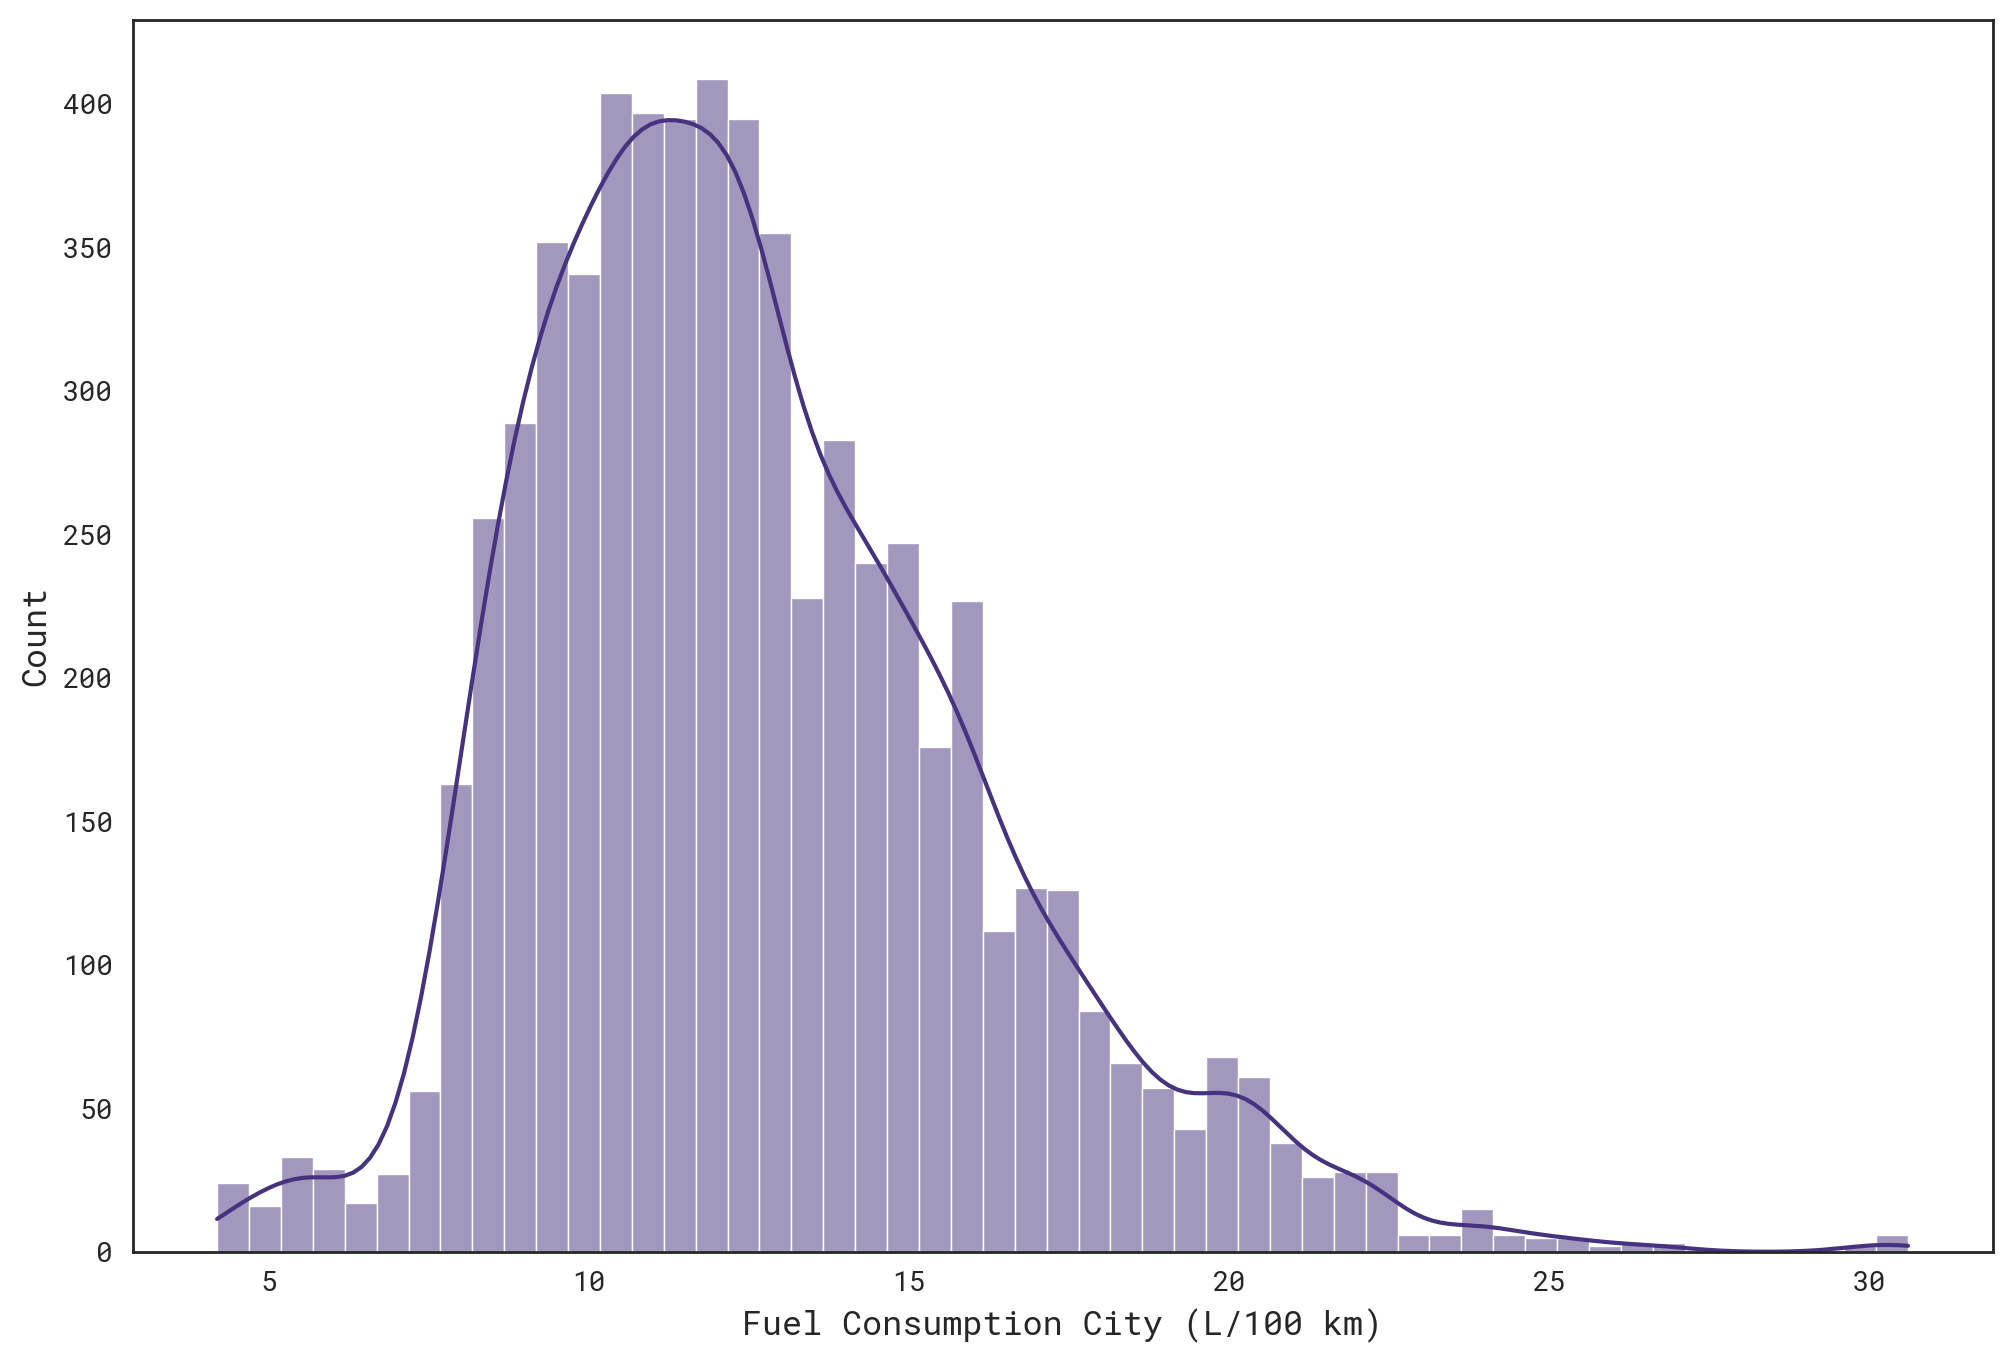

In [13]:
sns.histplot(df, x=NUMERICAL_FEATURES[2], kde=True)
plt.show()

#### Fuel Consumption Highway (L/100km)

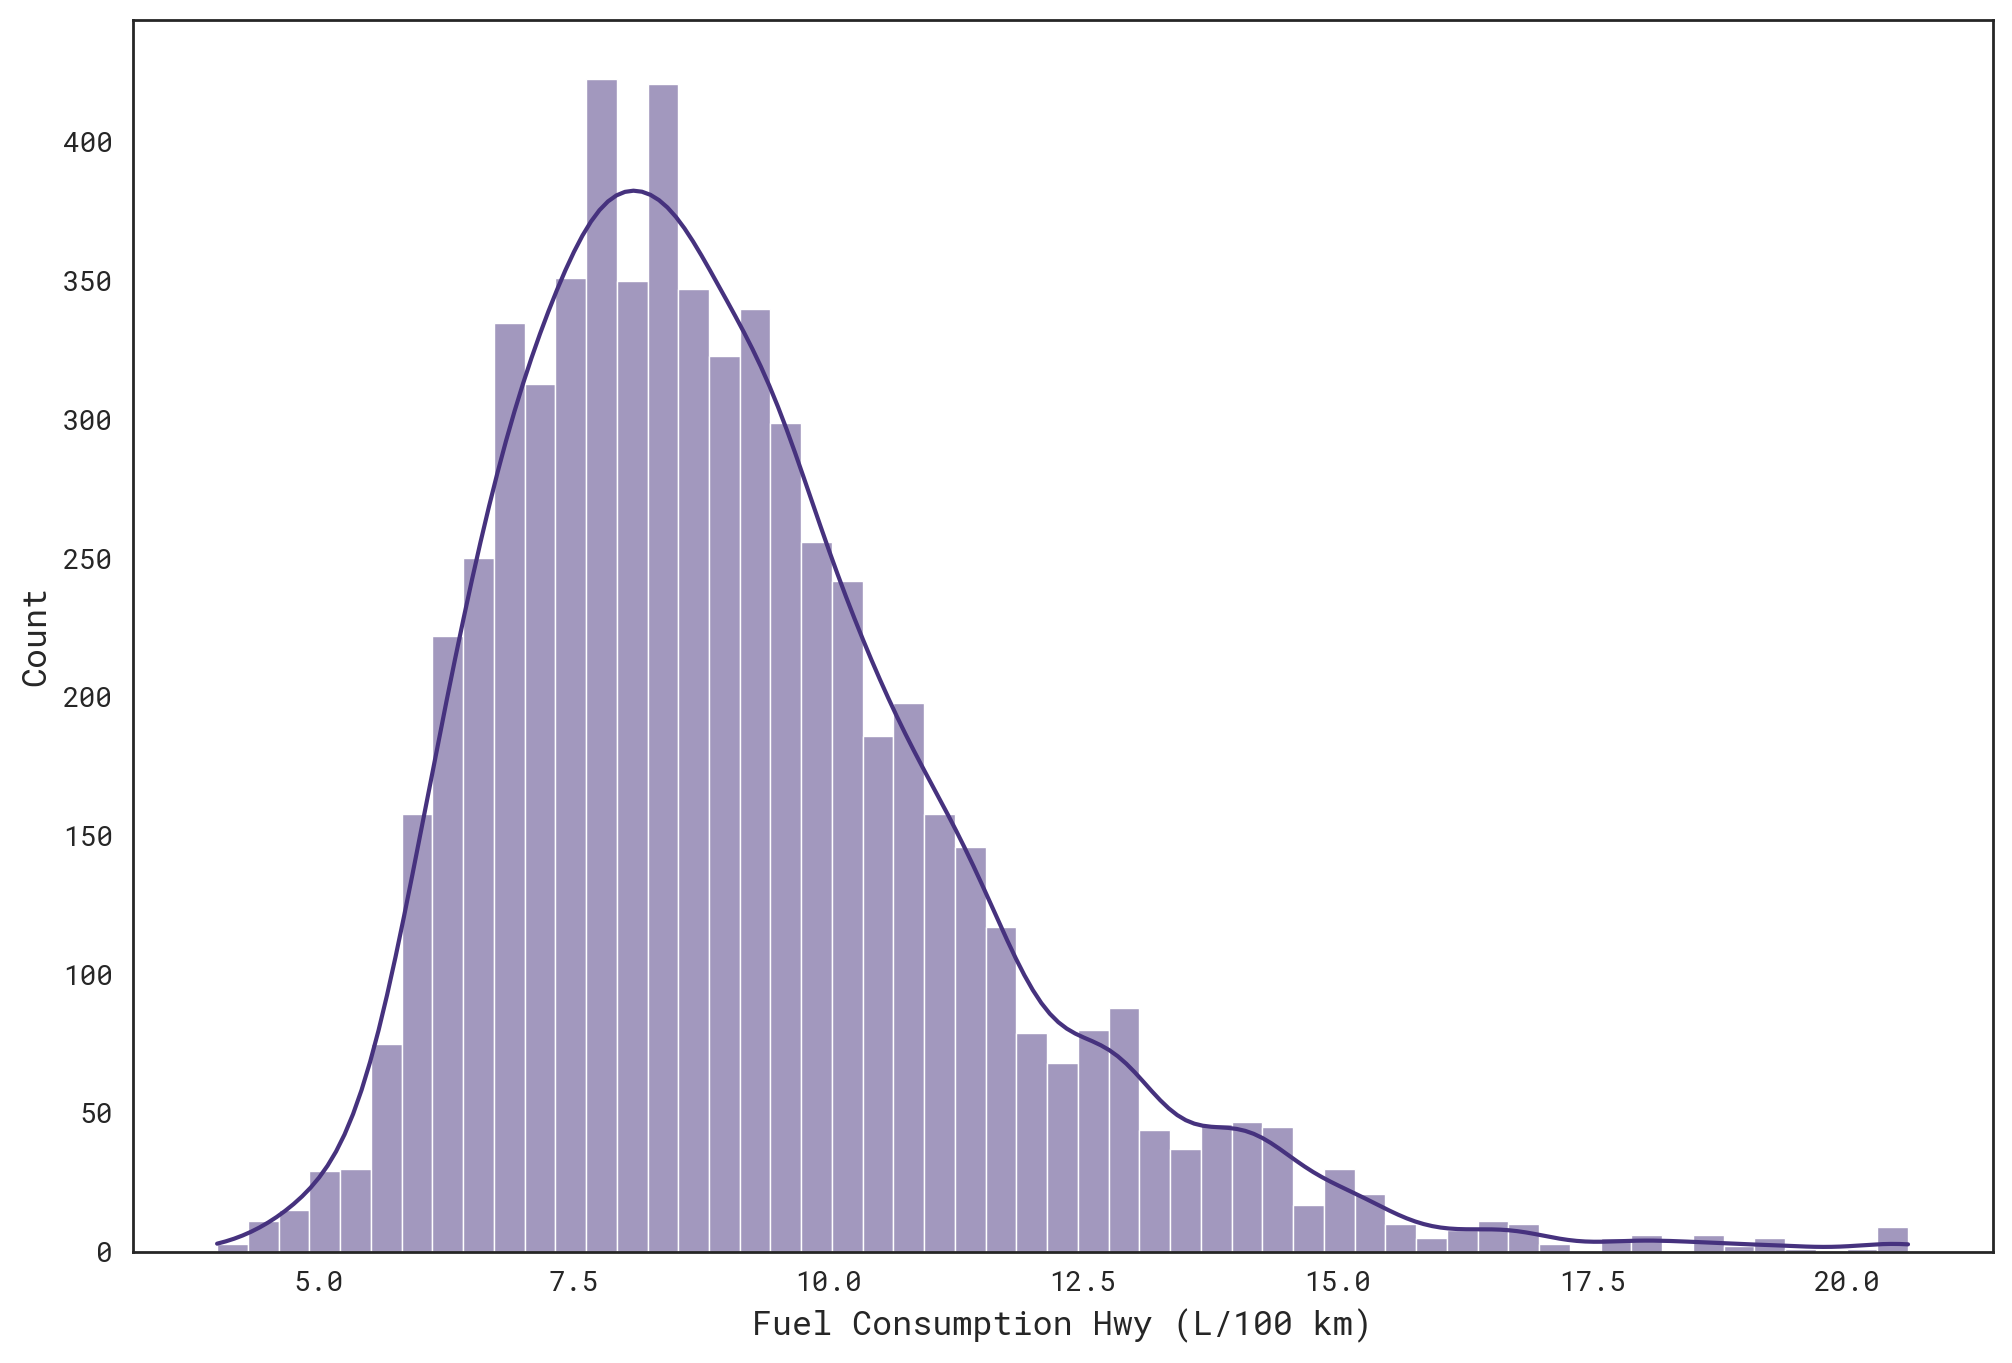

In [14]:
sns.histplot(df, x=NUMERICAL_FEATURES[3], kde=True)
plt.show()

#### Fuel Consumption Combined (MPG)

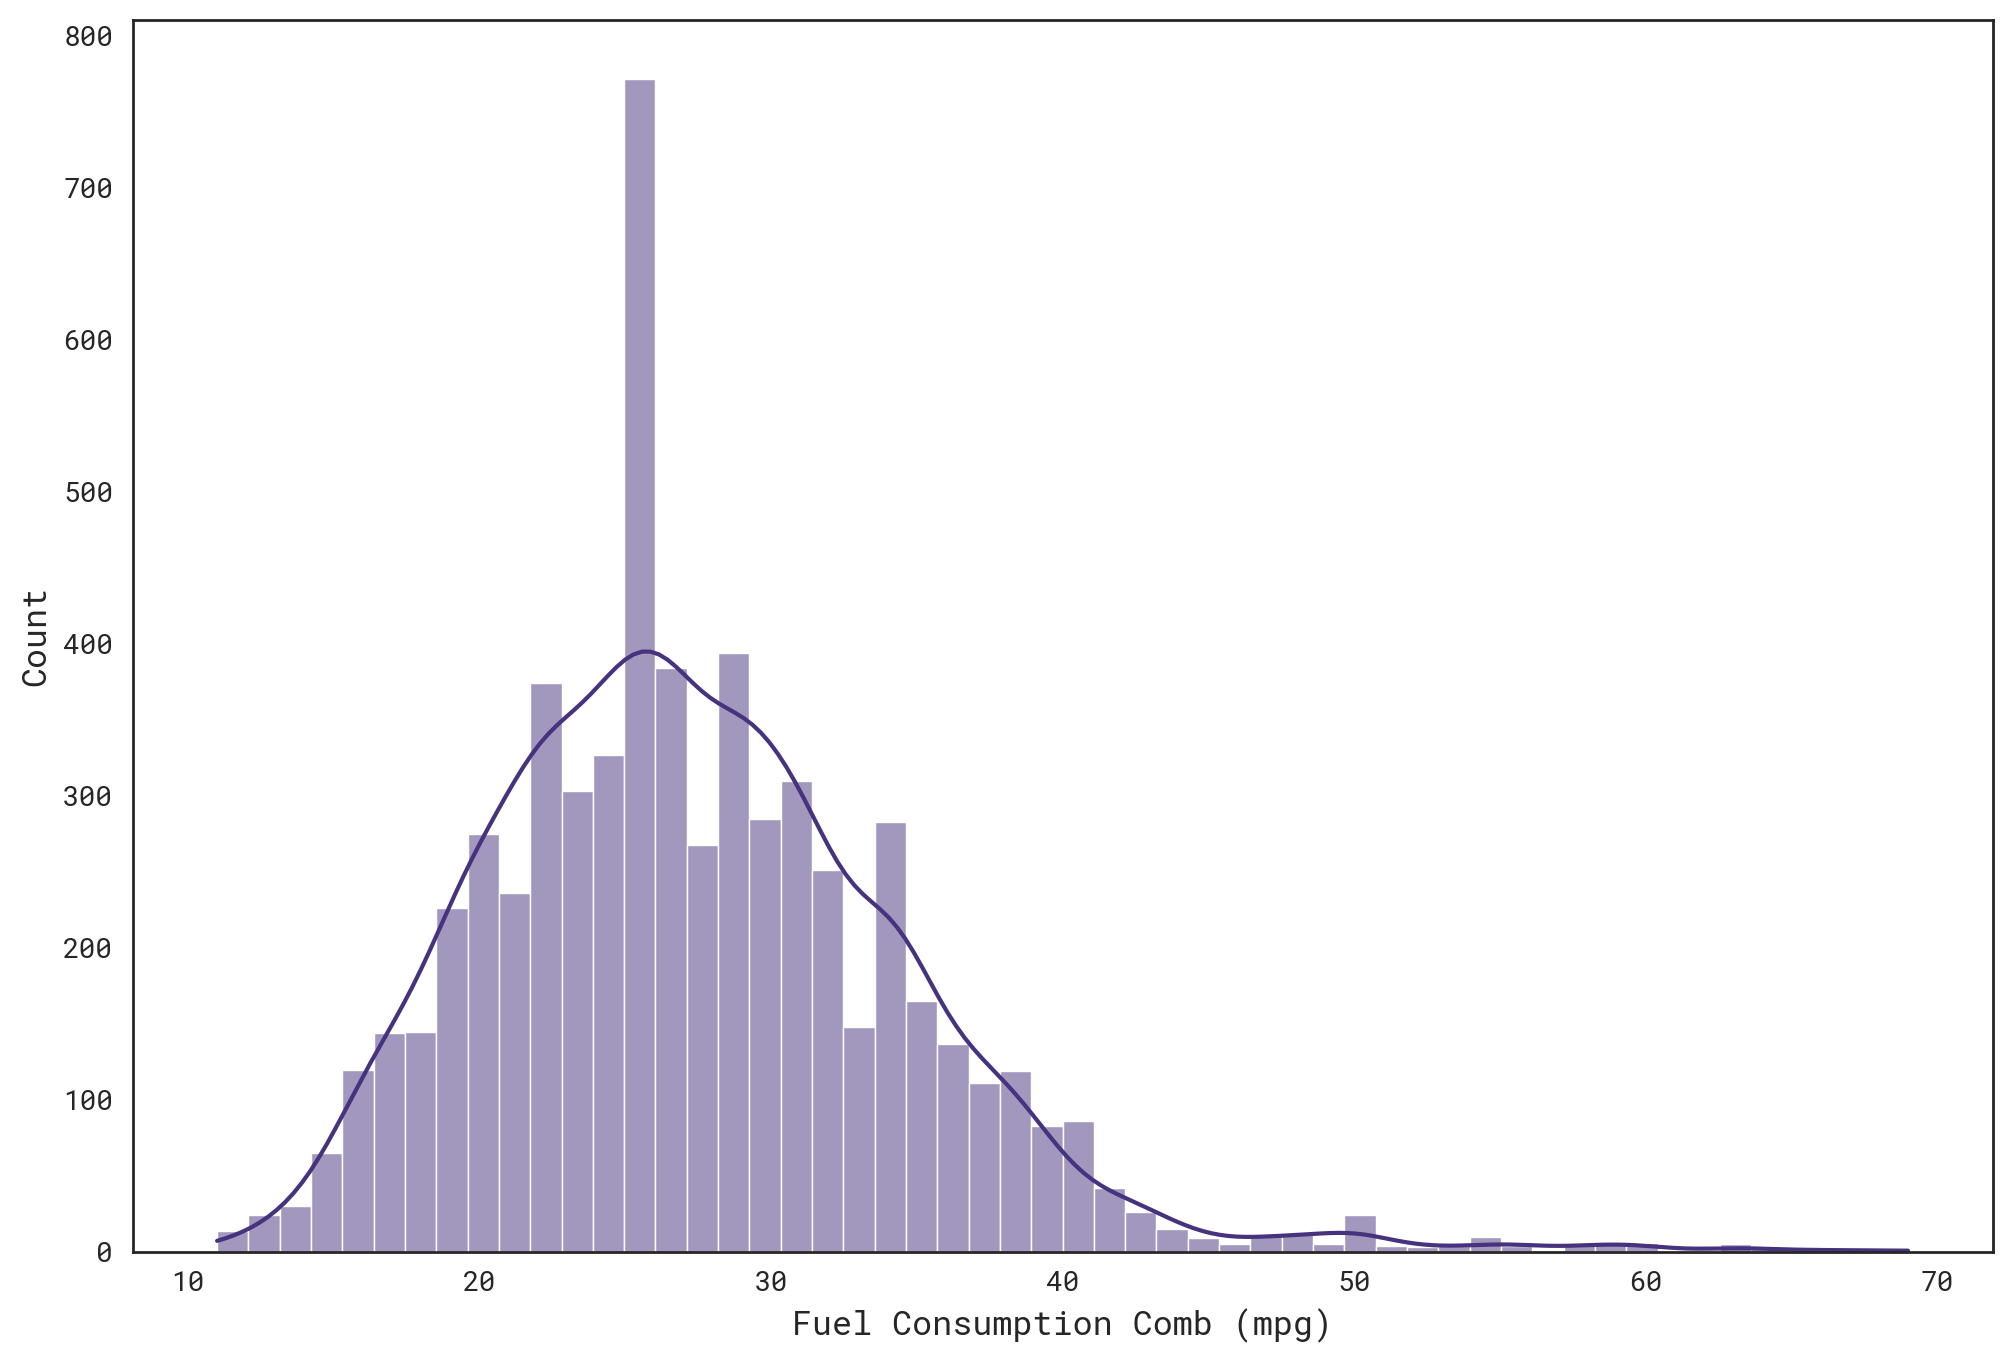

In [15]:
sns.histplot(df, x=NUMERICAL_FEATURES[5], kde=True)
plt.show()

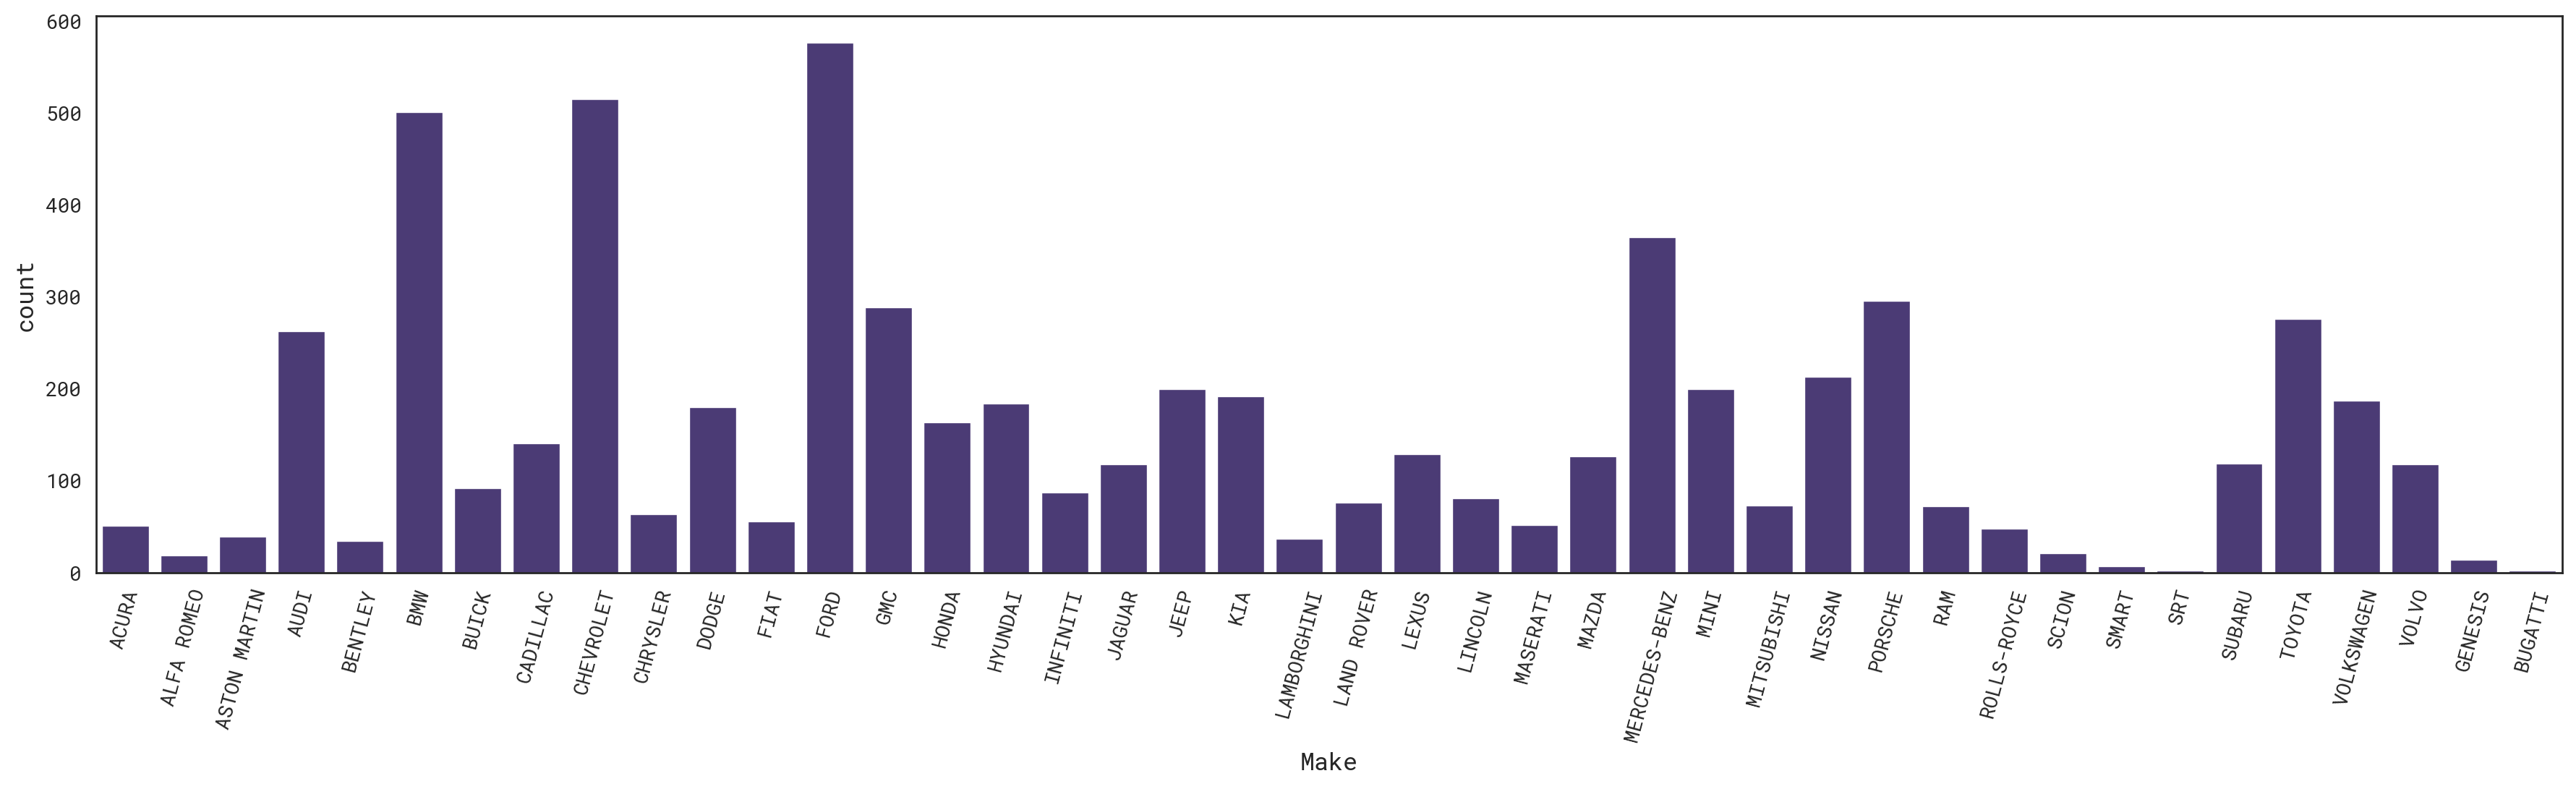

In [16]:
plt.figure(figsize=(22, 5))
sns.countplot(df, x='Make')
plt.xticks(rotation=75)
plt.show()

In [17]:
df['Model'].value_counts(sort=True, ascending=False)

Model
F-150 FFV             32
F-150 FFV 4X4         31
MUSTANG               27
FOCUS FFV             24
F-150 4X4             20
                      ..
LS 500                 1
LS 500h                1
NX 300 AWD F SPORT     1
RX 350 L AWD           1
XC40 T4 AWD            1
Name: count, Length: 2053, dtype: int64

### 2.4.2 Bivariate Analysis

Cylinder feature's unique values: [3, 4, 5, 6, 8, 10, 12, 16]


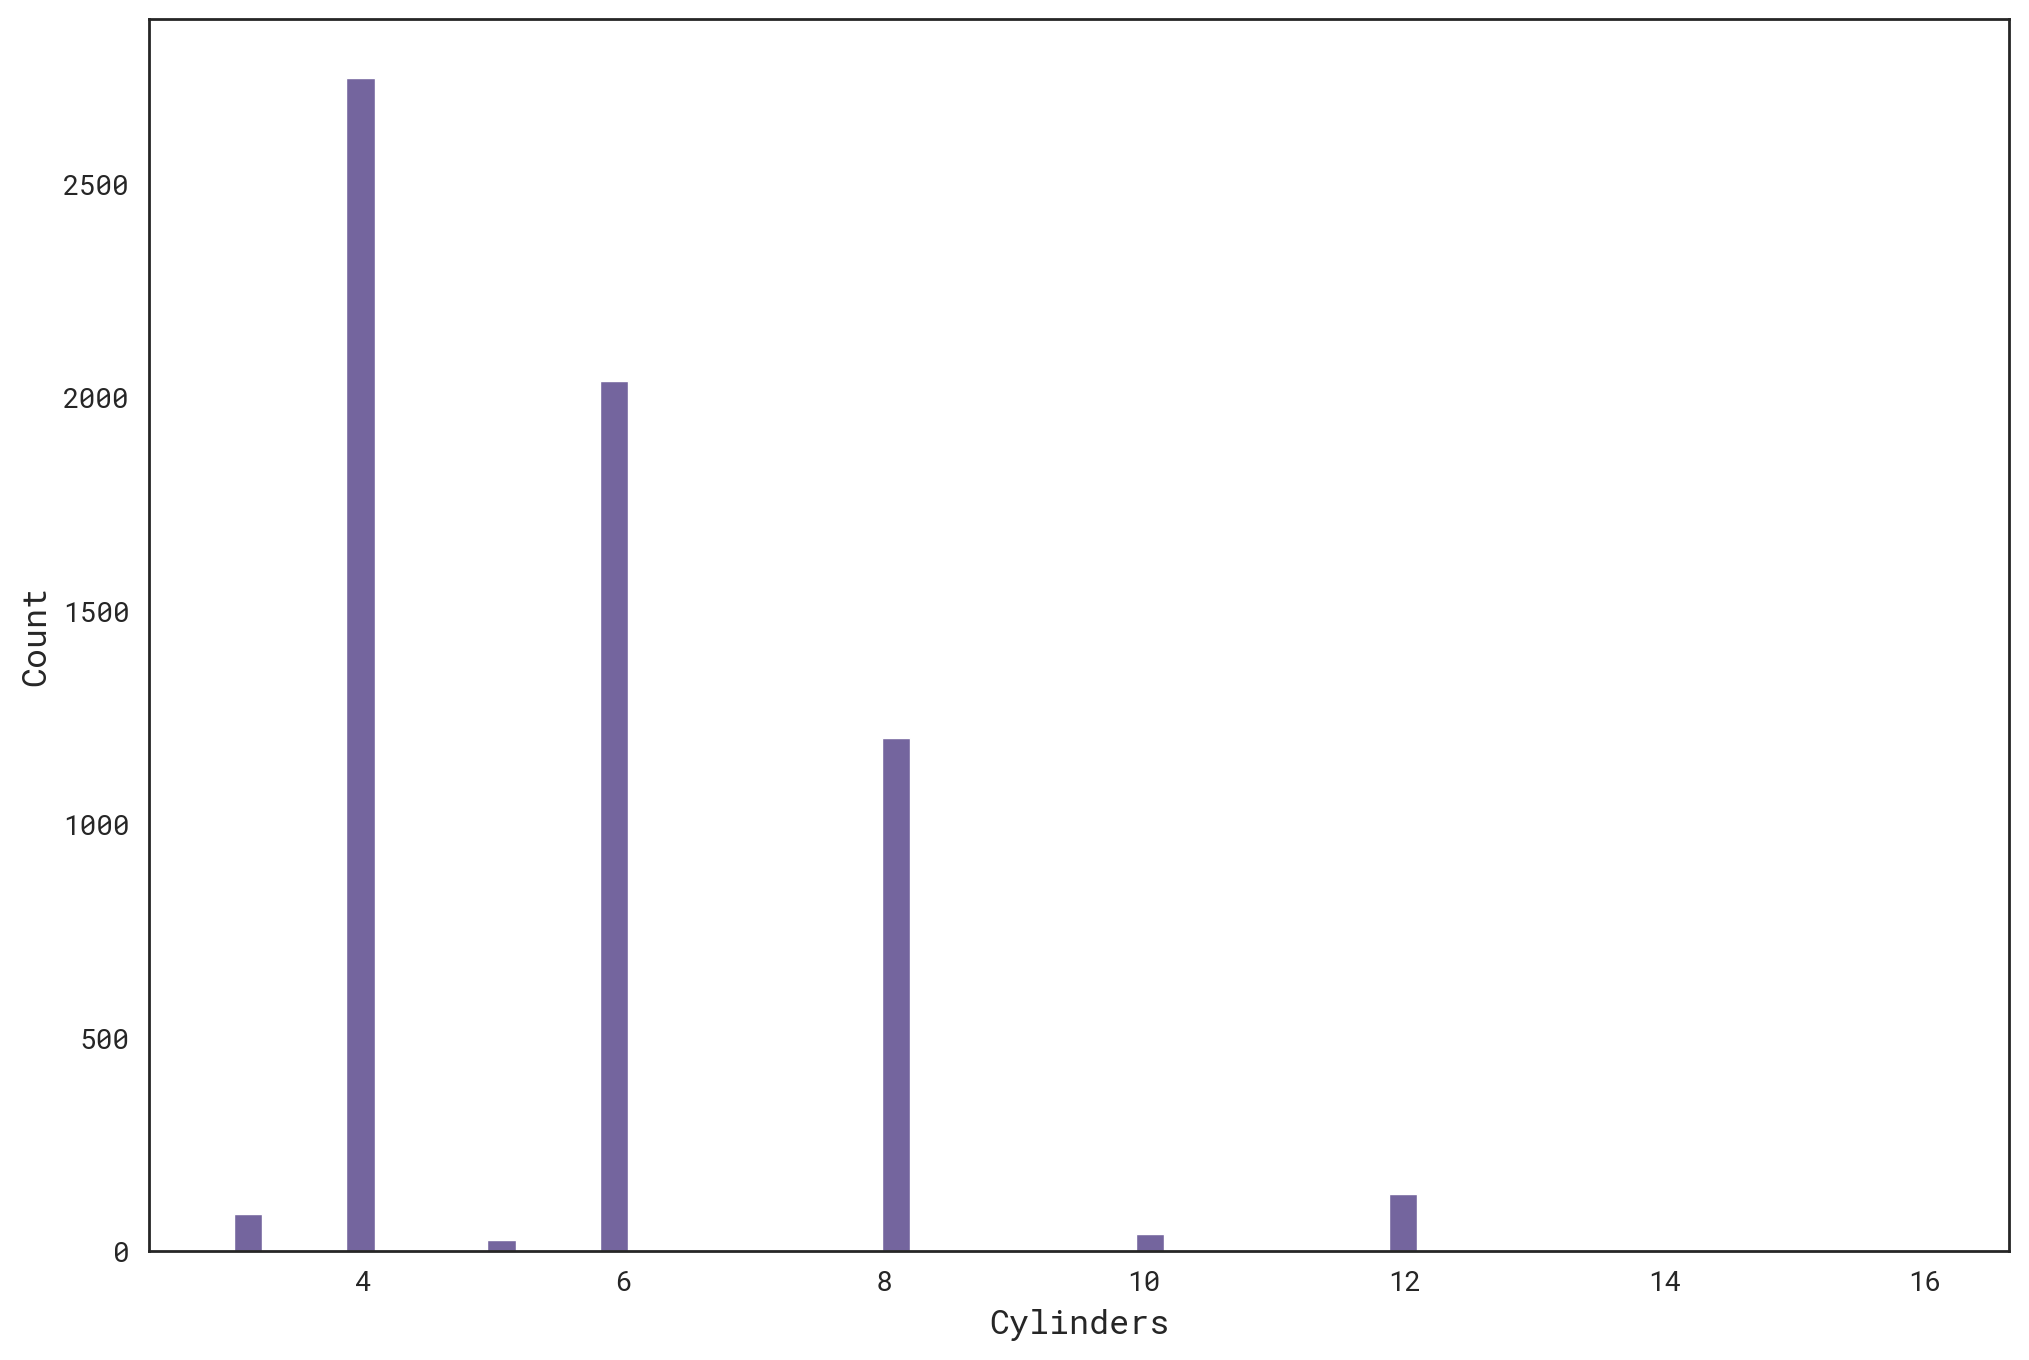

In [18]:
print("Cylinder feature's unique values:", sorted(df[NUMERICAL_FEATURES[1]].unique().tolist()))
sns.histplot(df, x=NUMERICAL_FEATURES[1], palette="viridis")
plt.show()

#### Seaborn Issue / Bug?
Compare the two graphs below. Both are Violinplots with Cyclinders as the category/hue, but one has it's legend completely incorrect.

I understand that to Seaborn, the numerical value "Cylinder" looks like a continuous variable, but if so, it should show those heatmap type continuous legends.

While the graph feels "incorrect", this is the intended behavior.

Link to the issue on GitHub where I mentioned the slightly unexpected result, and got an answer from the creator of Seaborn.
https://github.com/mwaskom/seaborn/issues/3841

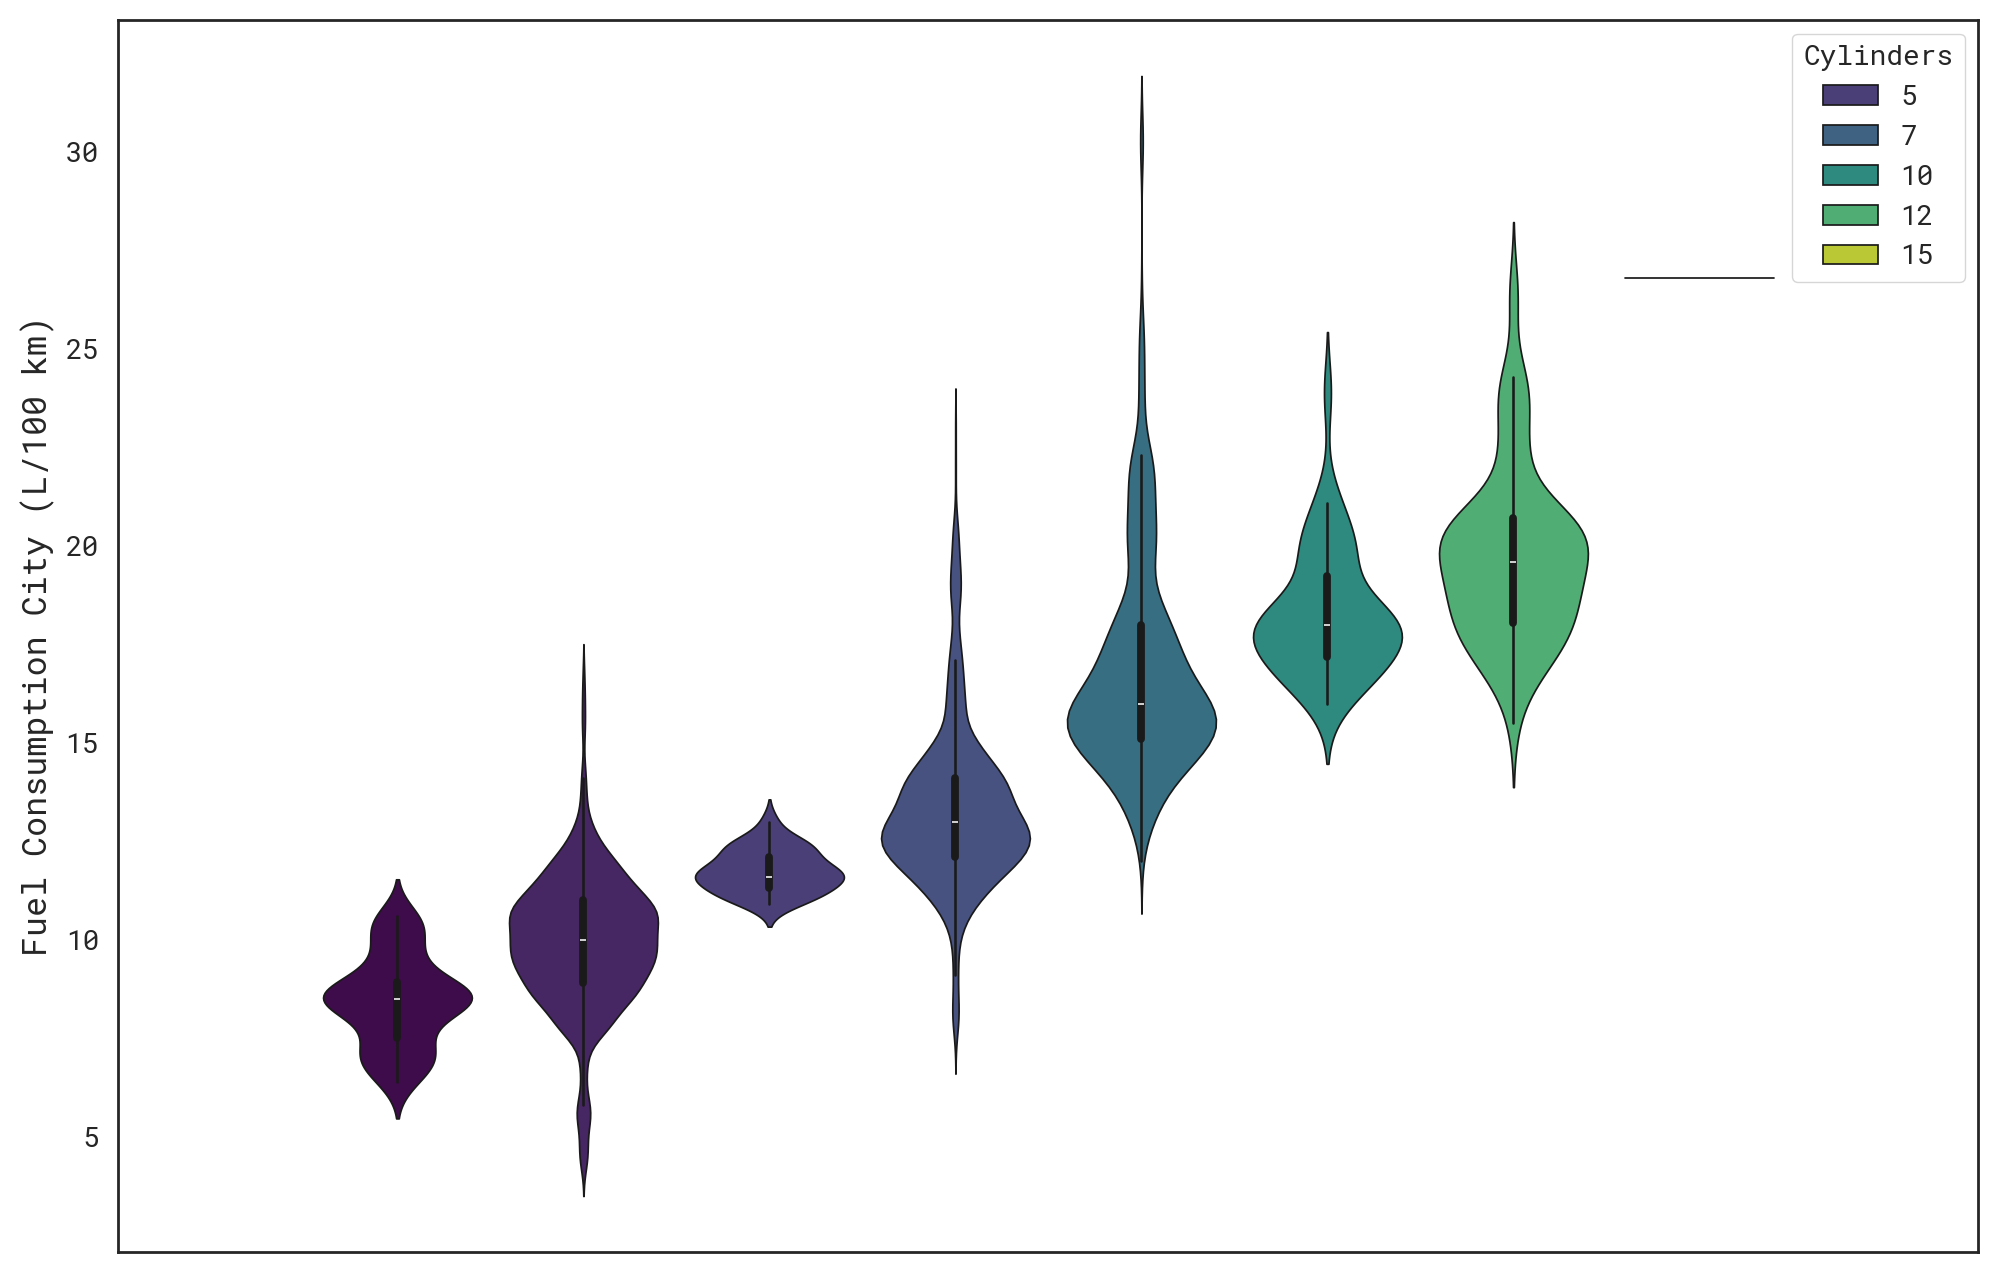

In [19]:
sns.violinplot(df, y=NUMERICAL_FEATURES[2], hue=NUMERICAL_FEATURES[1], gap=0.2, palette="viridis")
plt.show()

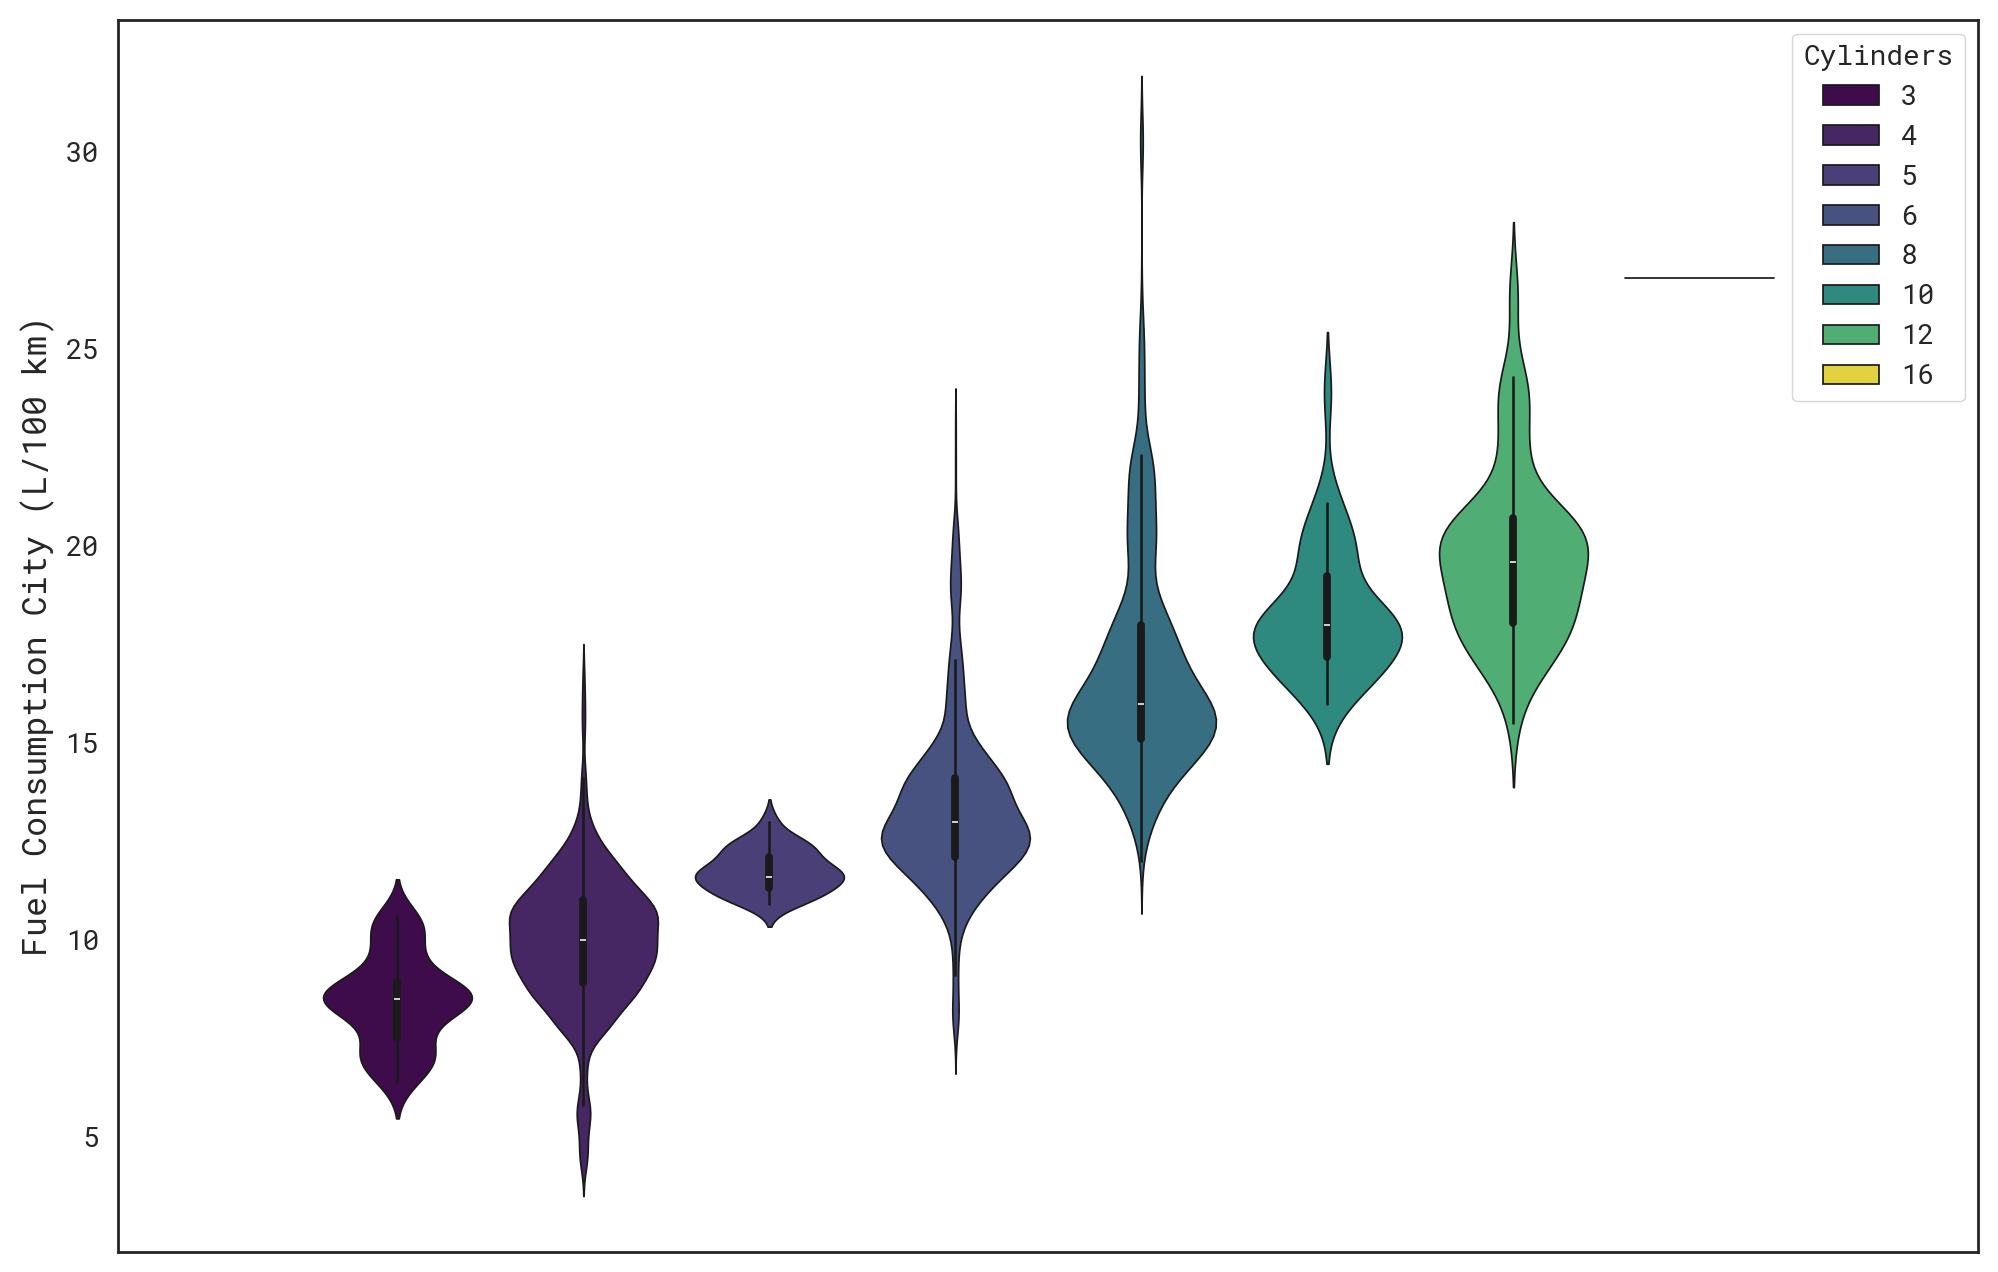

In [20]:
sns.violinplot(df, y=NUMERICAL_FEATURES[2], hue=NUMERICAL_FEATURES[1], gap=0.2, palette="viridis", legend="full")
plt.show()

In [21]:
# print(df.sample(30)['Make'].tolist())
# print(df.sample(30)['Fuel Consumption City (L/100 km)'].tolist())

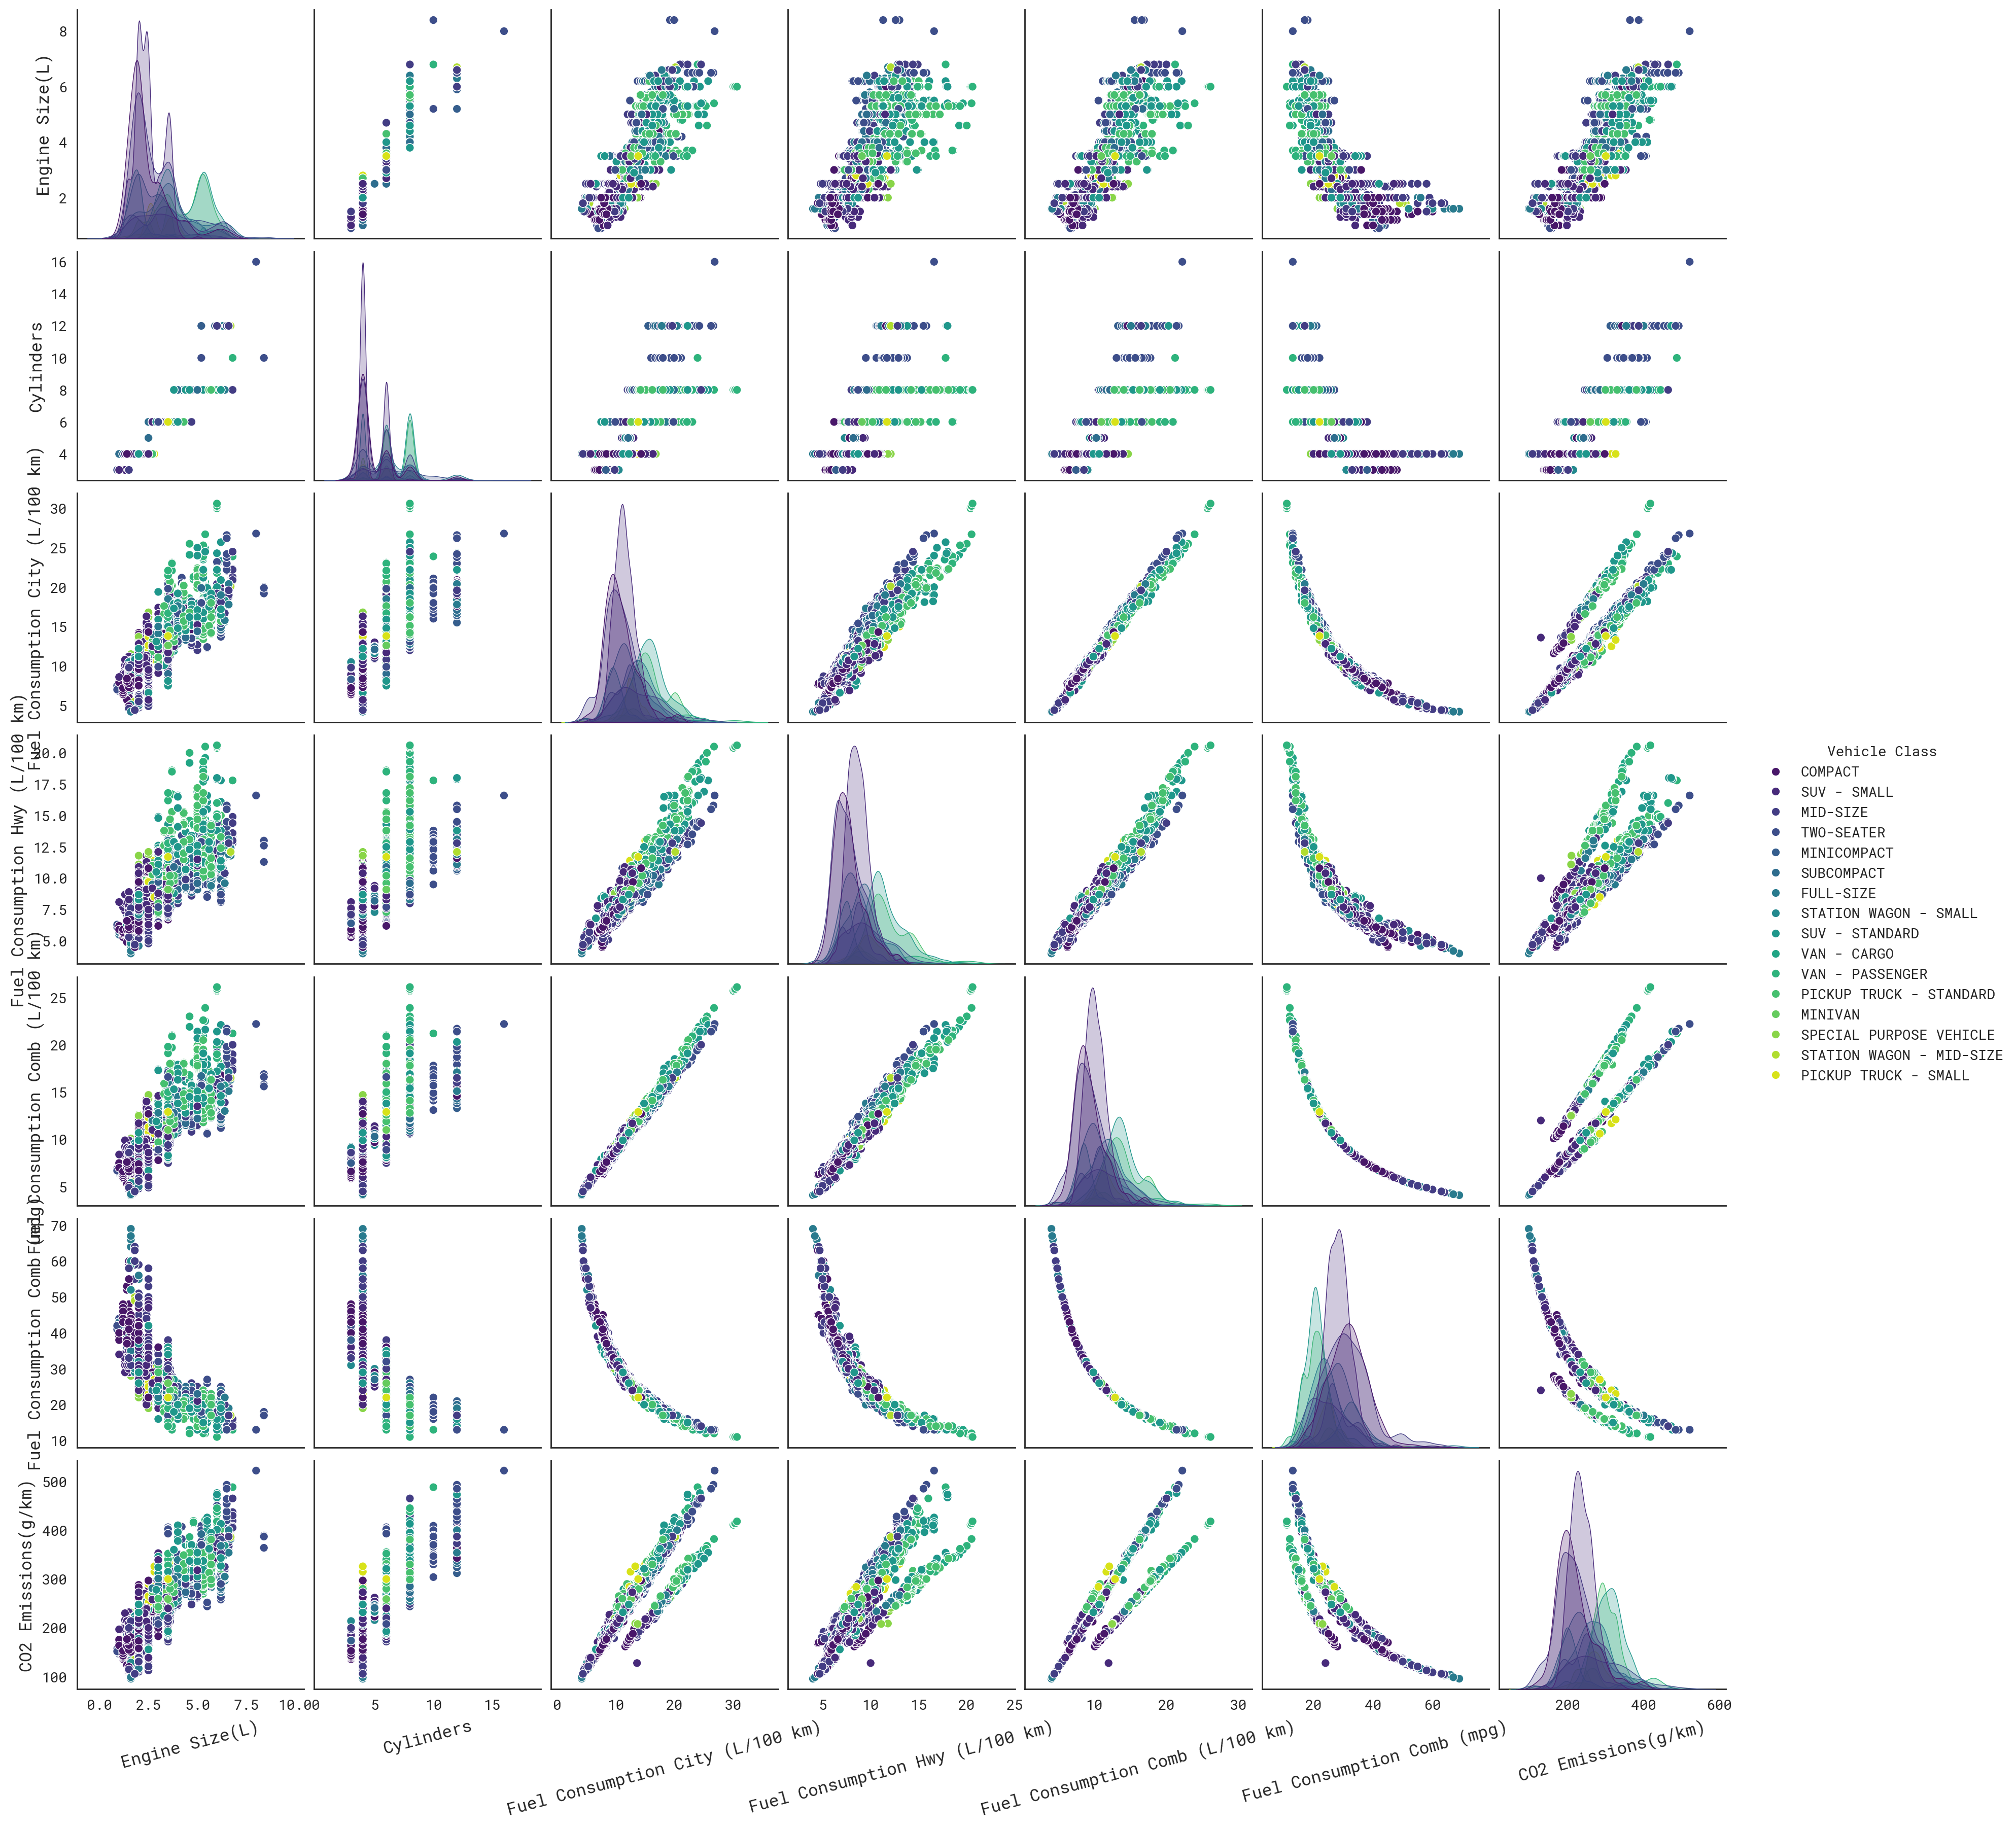

In [22]:
features = NUMERICAL_FEATURES + LABEL + ['Vehicle Class']
grid = sns.pairplot(df[features], hue="Vehicle Class", palette="viridis")
# plt.xticks(rotation=45)
for ax in grid.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 15)
    # ax.set_ylabel(ax.get_ylabel(), rotation = 75, x=1.0, y=0.5, rotation_mode='anchor')
    # ax.set_ylabel(ax.get_ylabel(), rotation = 75, position=(-1., 0.5), rotation_mode='anchor')
    # ax.set_ylabel(ax.get_ylabel(), rotation = 0, rotation_mode='default')
    ax.set_ylabel(ax.get_ylabel())
plt.show()

### 2.4.3 Target Variable Analysis
Let's check the distribution of the target variable.

It's a slightly right-shifted normal distribution, aka a slightly Positively skewed normal distribution.

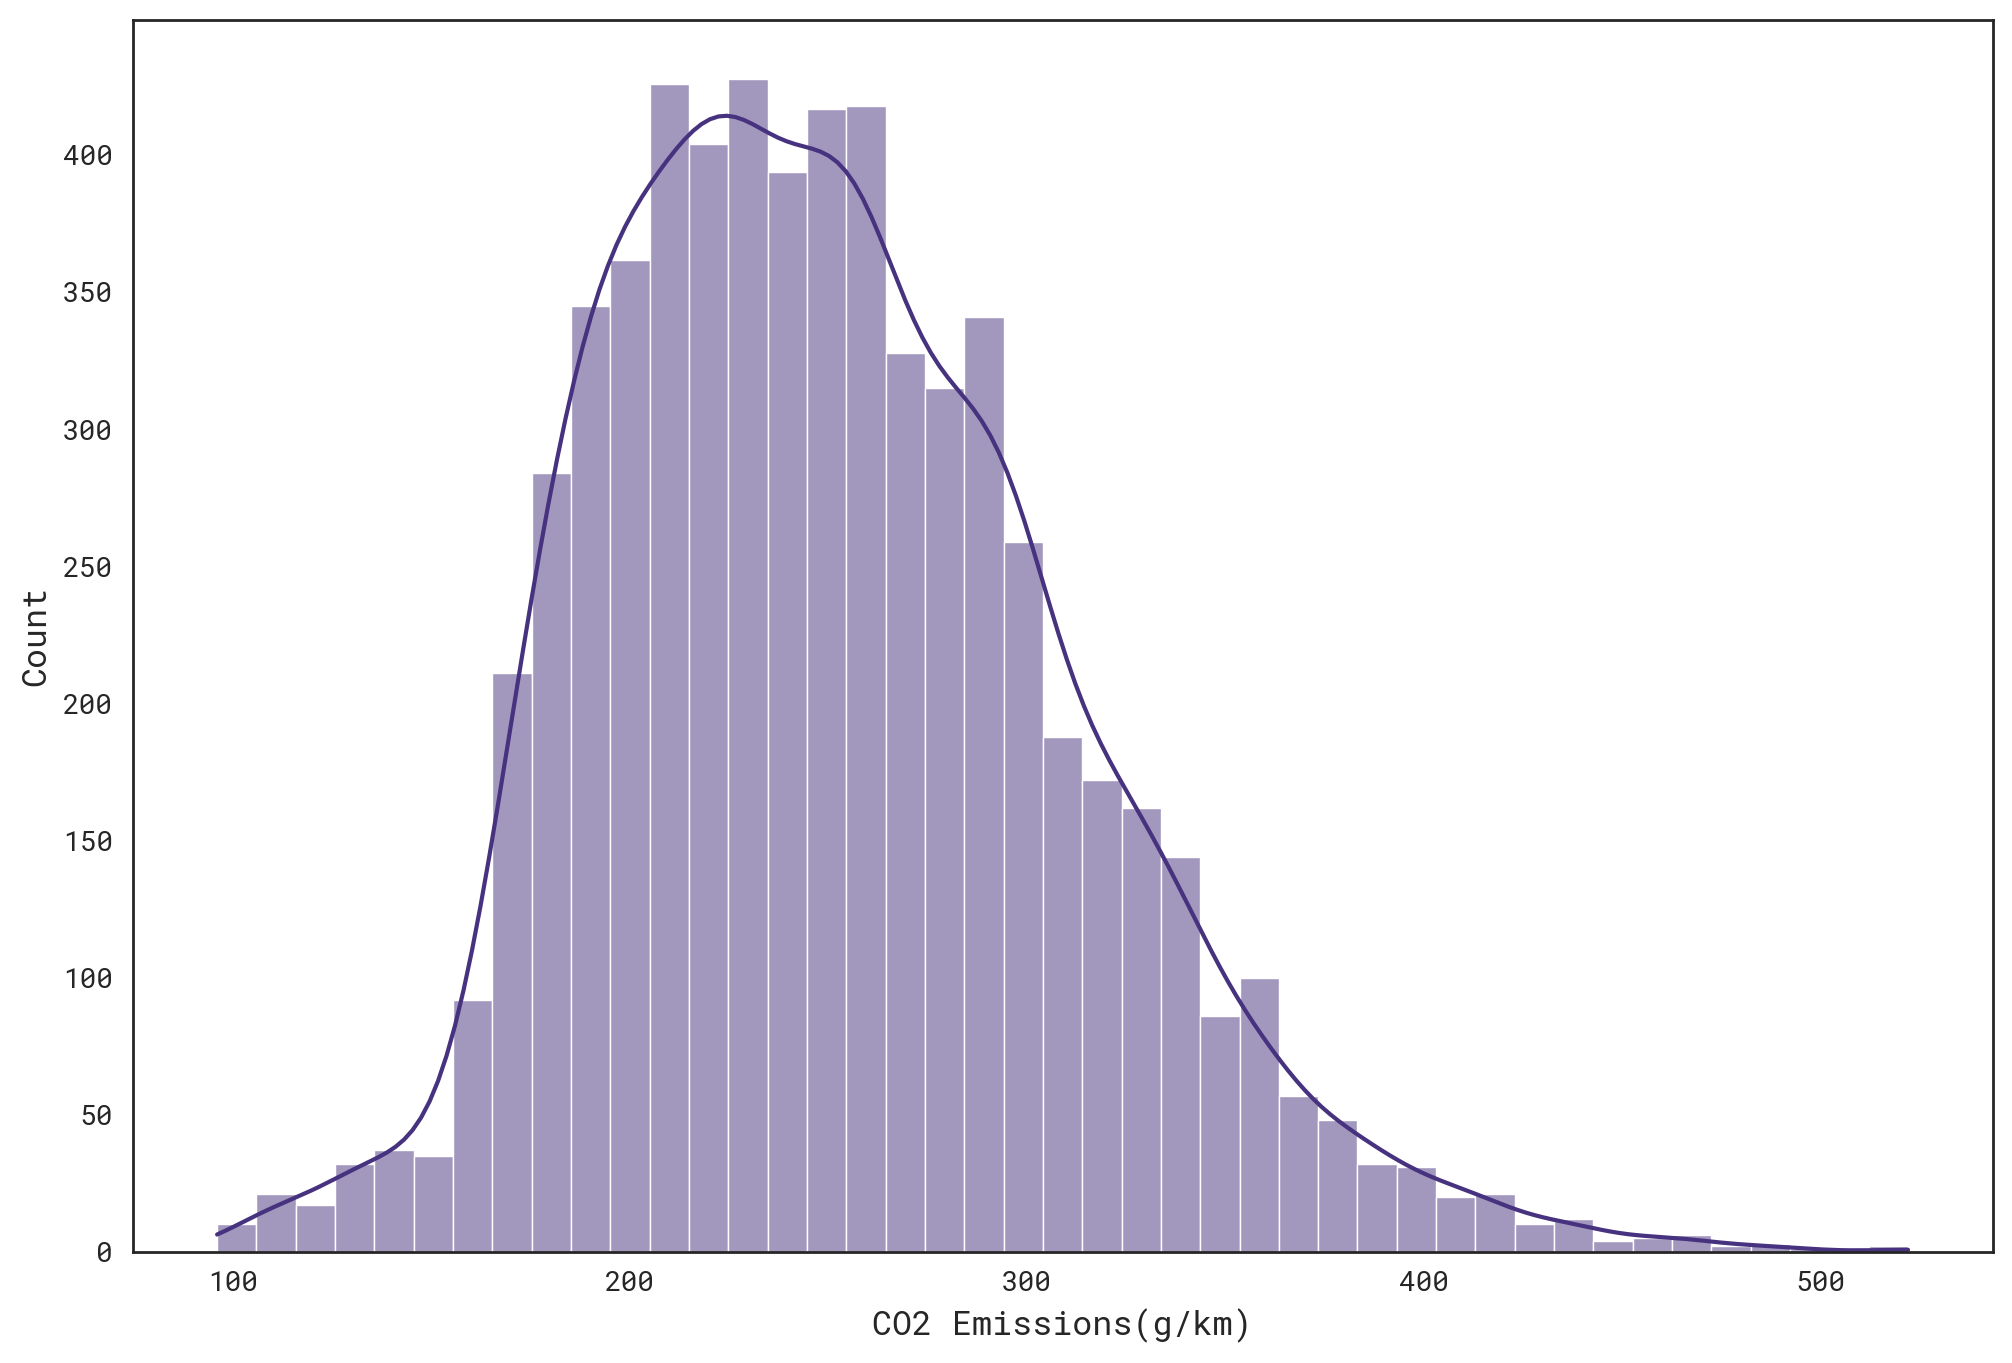

In [23]:
hp = sns.histplot(df, x=LABEL[0], binwidth=10, kde=True)
plt.show()

# 3. Data Preprocessing and Feature Engineering

## 3.1 Train Test Split
To prevent data leakage, split your data before performing feature engineering of any sort.

In [24]:
train, test = model_selection.train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
# Reset the indexes to prevent issues in concatenation, merge and other pandas methods.
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print(len(train), len(test))
train.head()

5025 1257


Make                  Model    Vehicle Class  Engine Size(L)  Cylinders  \
0      BMW           X3 xDrive30i      SUV - SMALL             2.0          4   
1      BMW  650i xDRIVE CABRIOLET       SUBCOMPACT             4.4          8   
2     FORD                MUSTANG       SUBCOMPACT             5.0          8   
3  PORSCHE                 CAYMAN       TWO-SEATER             2.7          6   
4      GMC  SAVANA 2500 PASSENGER  VAN - PASSENGER             6.0          8   

  Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
0          AS8         Z                              10.0   
1           A8         Z                              15.0   
2          AS6         X                              14.9   
3          AM7         Z                              10.7   
4           A6         X                              22.0   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              8.2                               9.2   
1                              9.8                              12.7   
2                              9.5                              12.4   
3                              7.4                               9.2   
4                             14.9                              18.8   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           31                  215  
1                           22                  292  
2                           23                  285  
3                           31                  217  
4                           15                  432

In [25]:
# train.to_csv("train.csv")
# test.to_csv("test.csv")

## 3.2 Feature Engineering

### 3.2.1 Feature Scaling
Let's perform feature scaling to ensure that our model converges quickly and predicts well.
#### Normalization
- This scales data to a specific range, often between 0 and 1, by adjusting values relative to the minimum and maximum of the dataset.

#### Standardization
- This transforms data to have a mean of 0 and a standard deviation of 1, by subtracting the mean and dividing by the standard deviation.

In this dataset, since all the numerical features are in the range of 0 to ~30, except for Fuel Consumption (MPG), the need for scaling is less critical. The decision should depend on the specific machie learning algorithm and the desired model performance.

In [26]:
COLUMNS = df.columns.tolist()
FEATURES_TO_SCALE = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)']
REMAINDER_FEATURES = [feature for feature in COLUMNS if feature not in FEATURES_TO_SCALE]

In [27]:
robust_scaler = RobustScaler()

scaler = ColumnTransformer(
    transformers=[
        ('robust', robust_scaler, FEATURES_TO_SCALE),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

x_train_scaled = scaler.fit_transform(train)

# # Method where you rearrange columns after transforming the columns directly, by using remainder='passthrough'.
# x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=preprocessor.get_feature_names_out())
# x_train_scaled_df = x_train_scaled_df[COLUMNS]

# Method where you drop columns while transforming the columns, and concat with remaining columns to maintain certain order.
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=scaler.get_feature_names_out())
x_train_df = pd.concat([train[REMAINDER_FEATURES], x_train_scaled_df], axis=1, sort=False)

print("Original Data:")
display(train.head())
print("\nScaled Data (using RobustScaler on specified columns):")
display(x_train_df.head())

Original Data:


Make                  Model    Vehicle Class  Engine Size(L)  Cylinders  \
0      BMW           X3 xDrive30i      SUV - SMALL             2.0          4   
1      BMW  650i xDRIVE CABRIOLET       SUBCOMPACT             4.4          8   
2     FORD                MUSTANG       SUBCOMPACT             5.0          8   
3  PORSCHE                 CAYMAN       TWO-SEATER             2.7          6   
4      GMC  SAVANA 2500 PASSENGER  VAN - PASSENGER             6.0          8   

  Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
0          AS8         Z                              10.0   
1           A8         Z                              15.0   
2          AS6         X                              14.9   
3          AM7         Z                              10.7   
4           A6         X                              22.0   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              8.2                               9.2   
1                              9.8                              12.7   
2                              9.5                              12.4   
3                              7.4                               9.2   
4                             14.9                              18.8   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           31                  215  
1                           22                  292  
2                           23                  285  
3                           31                  217  
4                           15                  432


Scaled Data (using RobustScaler on specified columns):


Make                  Model    Vehicle Class Transmission Fuel Type  \
0      BMW           X3 xDrive30i      SUV - SMALL          AS8         Z   
1      BMW  650i xDRIVE CABRIOLET       SUBCOMPACT           A8         Z   
2     FORD                MUSTANG       SUBCOMPACT          AS6         X   
3  PORSCHE                 CAYMAN       TWO-SEATER          AM7         Z   
4      GMC  SAVANA 2500 PASSENGER  VAN - PASSENGER           A6         X   

   CO2 Emissions(g/km)  Engine Size(L)  Cylinders  \
0                  215       -0.588235       -1.0   
1                  292        0.823529        1.0   
2                  285        1.176471        1.0   
3                  217       -0.176471        0.0   
4                  432        1.764706        1.0   

   Fuel Consumption City (L/100 km)  Fuel Consumption Hwy (L/100 km)  \
0                         -0.444444                        -0.185185   
1                          0.666667                         0.407407   
2                          0.644444                         0.296296   
3                         -0.288889                        -0.481481   
4                          2.222222                         2.296296   

   Fuel Consumption Comb (L/100 km)  Fuel Consumption Comb (mpg)  
0                         -0.351351                          0.4  
1                          0.594595                         -0.5  
2                          0.513514                         -0.4  
3                         -0.351351                          0.4  
4                          2.243243                         -1.2

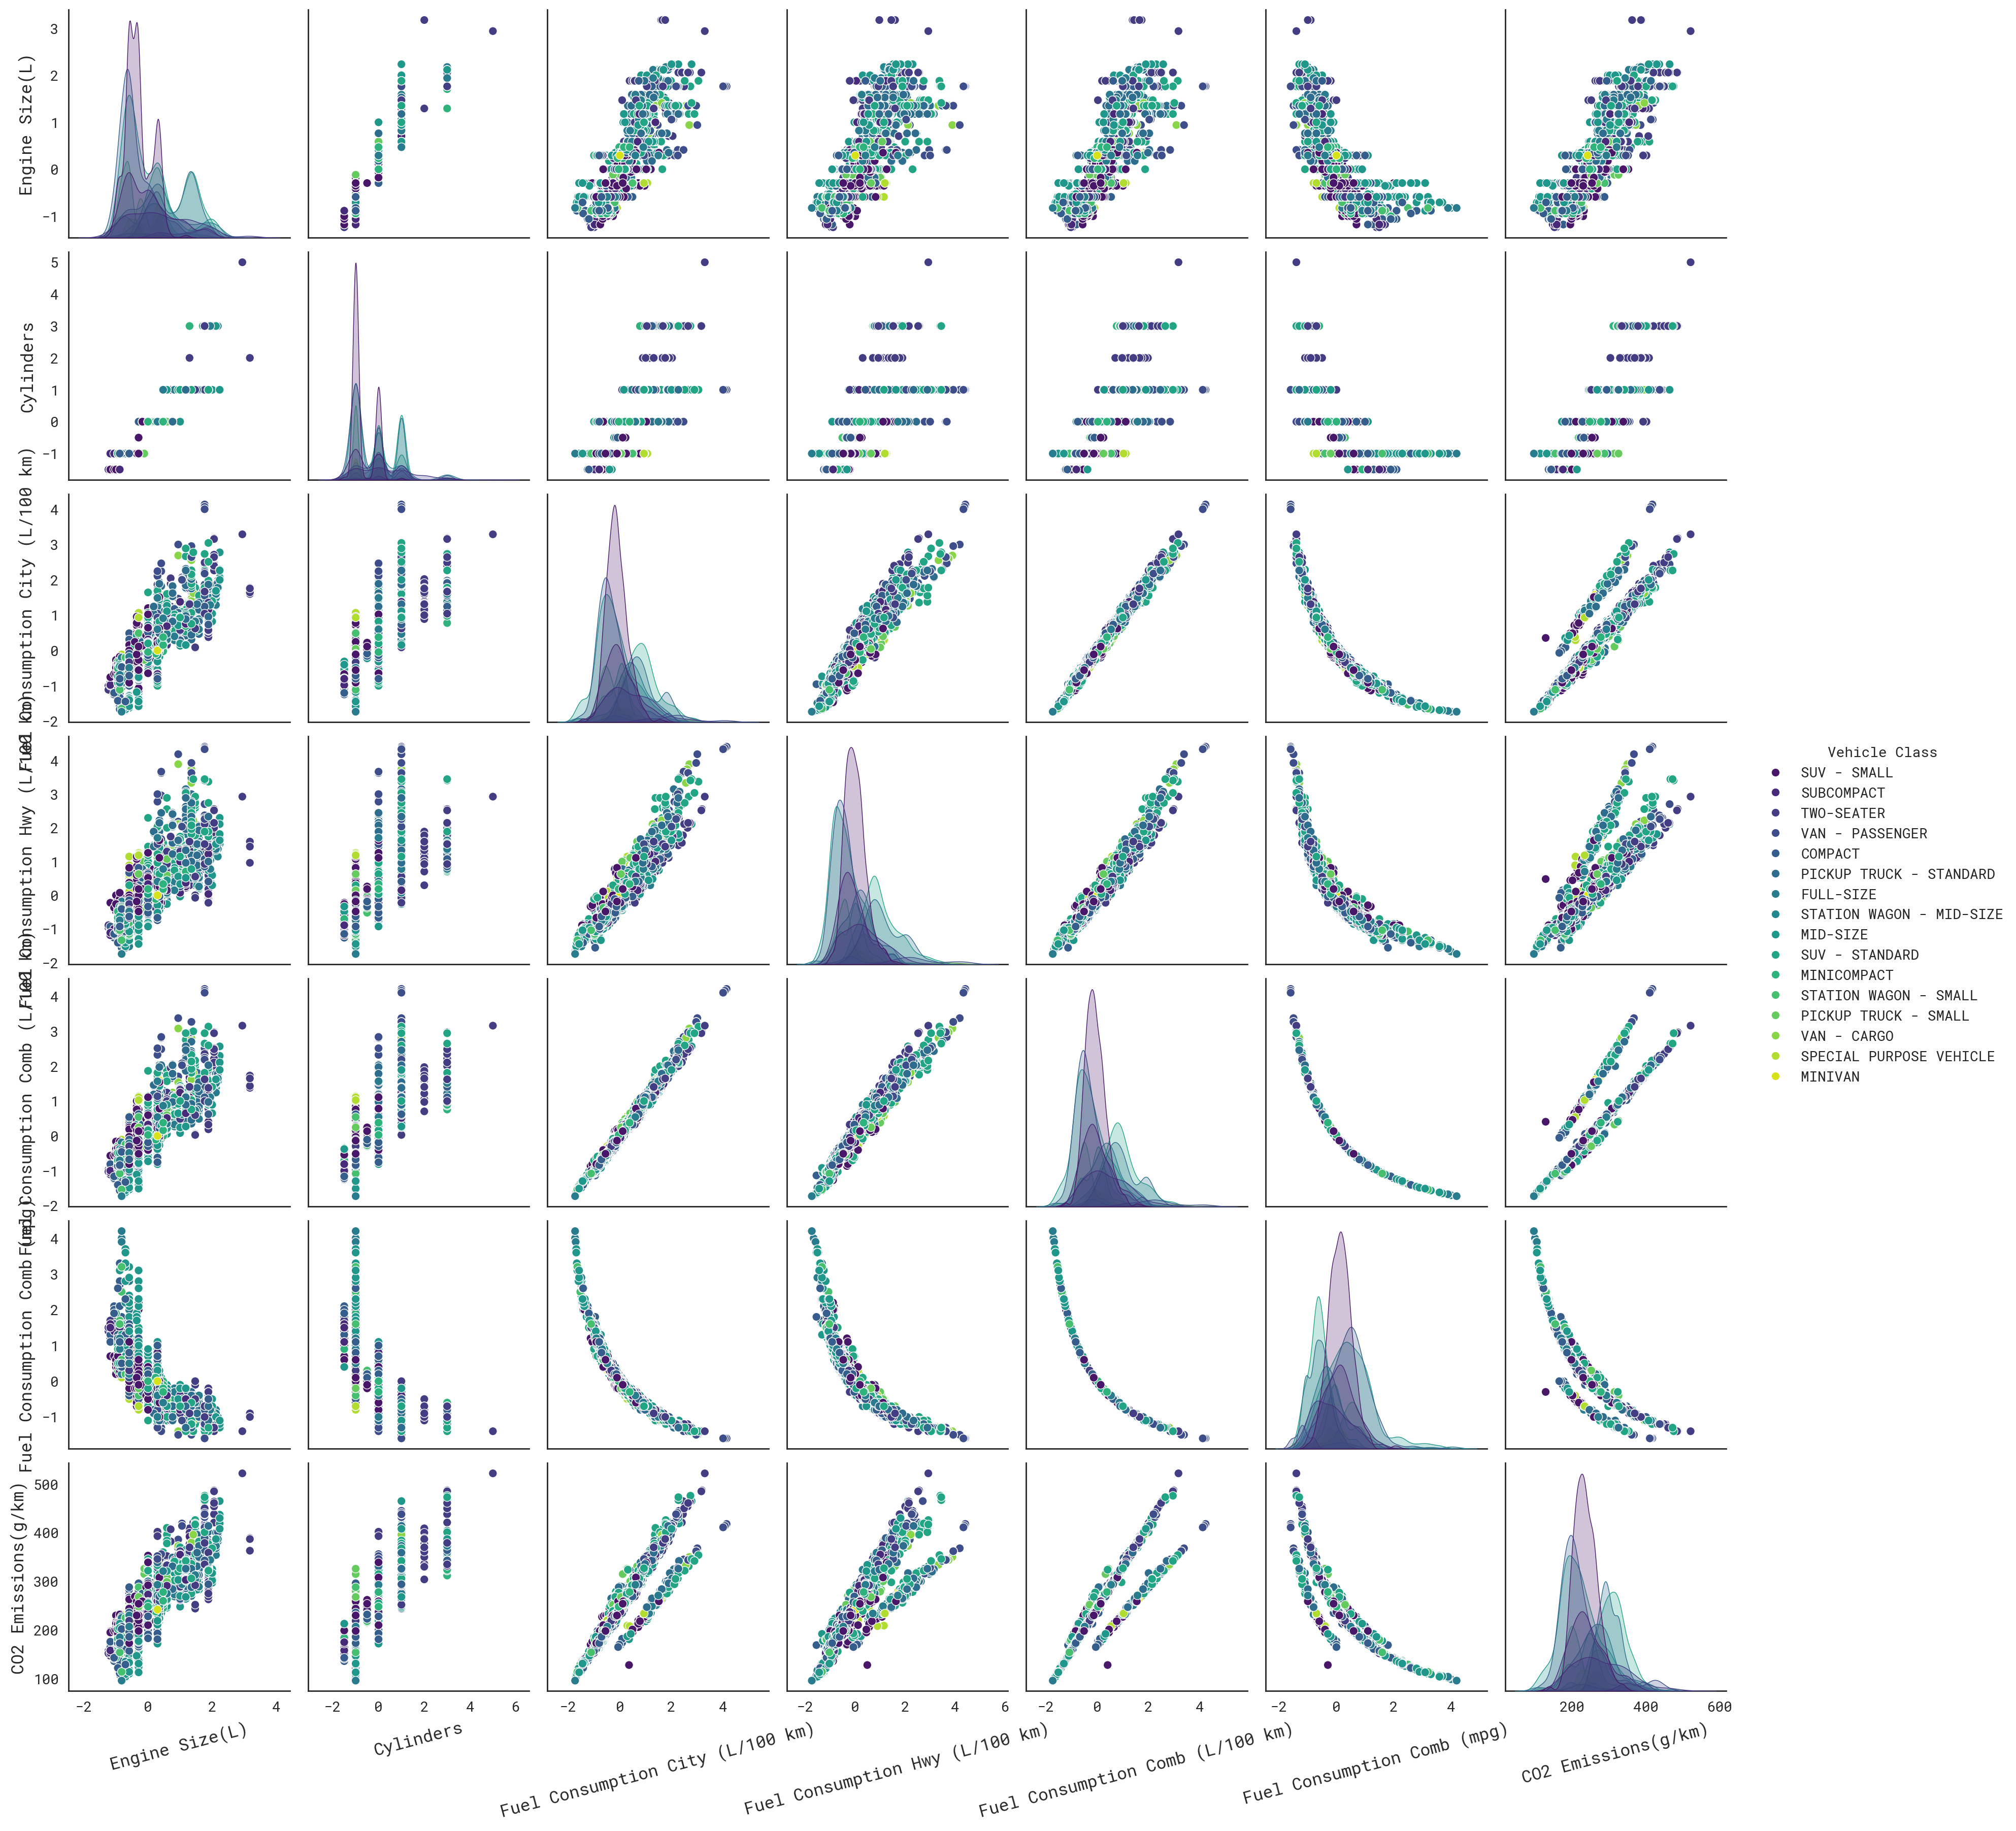

In [28]:
features = NUMERICAL_FEATURES + LABEL + ['Vehicle Class']
grid = sns.pairplot(x_train_df[features], hue="Vehicle Class", palette="viridis")
for ax in grid.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 15)
    ax.set_ylabel(ax.get_ylabel())
# grid.title("Pair Plot of Features & Label after Feature Scaling")
plt.show()

### 3.2.2 Feature Encoding

In [29]:
train[CATEGORICAL_FEATURES].nunique()

Make               42
Model            1892
Vehicle Class      16
Transmission       27
Fuel Type           4
dtype: int64

In [30]:
ohe_make = OneHotEncoder(sparse_output=False, dtype=int)

ohe_make.fit(train[['Make']])
print(ohe_make.categories_)

make_ohe_mat = ohe_make.transform(train[['Make']])
print(make_ohe_mat[0])
# If sparse_output = True, we need to generate the full matrix first, that's where .toarray() comes in.
# make_df = pd.DataFrame(make_ohe_mat.toarray(), columns=ohe.categories_[0])
make_df = pd.DataFrame(make_ohe_mat, columns=ohe_make.categories_[0])
make_df.head()

[array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUGATTI', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
       'FIAT', 'FORD', 'GENESIS', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI',
       'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS',
       'LINCOLN', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ', 'MINI',
       'MITSUBISHI', 'NISSAN', 'PORSCHE', 'RAM', 'ROLLS-ROYCE', 'SCION',
       'SMART', 'SRT', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO'],
      dtype=object)]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


ACURA  ALFA ROMEO  ASTON MARTIN  AUDI  BENTLEY  BMW  BUGATTI  BUICK  \
0      0           0             0     0        0    1        0      0   
1      0           0             0     0        0    1        0      0   
2      0           0             0     0        0    0        0      0   
3      0           0             0     0        0    0        0      0   
4      0           0             0     0        0    0        0      0   

   CADILLAC  CHEVROLET  ...  PORSCHE  RAM  ROLLS-ROYCE  SCION  SMART  SRT  \
0         0          0  ...        0    0            0      0      0    0   
1         0          0  ...        0    0            0      0      0    0   
2         0          0  ...        0    0            0      0      0    0   
3         0          0  ...        1    0            0      0      0    0   
4         0          0  ...        0    0            0      0      0    0   

   SUBARU  TOYOTA  VOLKSWAGEN  VOLVO  
0       0       0           0      0  
1       0       0           0      0  
2       0       0           0      0  
3       0       0           0      0  
4       0       0           0      0  

[5 rows x 42 columns]

In [31]:
ohe = OneHotEncoder(sparse_output=False, dtype=int)

encoder = ColumnTransformer(
    transformers=[
        ('one-hot-encoding', ohe, CATEGORICAL_FEATURES),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

encoded_mat = encoder.fit_transform(train)

encoded_df = pd.DataFrame(encoded_mat, columns=encoder.get_feature_names_out())
# x_train_df = pd.concat([train[REMAINDER_FEATURES], encoded_df], axis=1, sort=False)
print("Original data:")
display(train[REMAINDER_FEATURES].head())
print("\nEncoded Data:")
display(encoded_df.head())

Original data:


Make                  Model    Vehicle Class Transmission Fuel Type  \
0      BMW           X3 xDrive30i      SUV - SMALL          AS8         Z   
1      BMW  650i xDRIVE CABRIOLET       SUBCOMPACT           A8         Z   
2     FORD                MUSTANG       SUBCOMPACT          AS6         X   
3  PORSCHE                 CAYMAN       TWO-SEATER          AM7         Z   
4      GMC  SAVANA 2500 PASSENGER  VAN - PASSENGER           A6         X   

   CO2 Emissions(g/km)  
0                  215  
1                  292  
2                  285  
3                  217  
4                  432


Encoded Data:


Make_ACURA  Make_ALFA ROMEO  Make_ASTON MARTIN  Make_AUDI  Make_BENTLEY  \
0           0                0                  0          0             0   
1           0                0                  0          0             0   
2           0                0                  0          0             0   
3           0                0                  0          0             0   
4           0                0                  0          0             0   

   Make_BMW  Make_BUGATTI  Make_BUICK  Make_CADILLAC  Make_CHEVROLET  ...  \
0         1             0           0              0               0  ...   
1         1             0           0              0               0  ...   
2         0             0           0              0               0  ...   
3         0             0           0              0               0  ...   
4         0             0           0              0               0  ...   

   Transmission_AV6  Transmission_AV7  Transmission_AV8  Transmission_M5  \
0                 0                 0                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 0                 0                0   
4                 0                 0                 0                0   

   Transmission_M6  Transmission_M7  Fuel Type_D  Fuel Type_E  Fuel Type_X  \
0                0                0            0            0            0   
1                0                0            0            0            0   
2                0                0            0            0            1   
3                0                0            0            0            0   
4                0                0            0            0            1   

   Fuel Type_Z  
0            1  
1            1  
2            0  
3            1  
4            0  

[5 rows x 1981 columns]

### 3.2.3 Pipeline Creation
Now that we have tried encoding and scaling column transformers, and verified the outputs, let's combine the two and create our pipeline.

#### Removing columns for dummies (Multicollinearity - Dummy variable trap)
Read more on the dummy variable trap: 
- https://www.learndatasci.com/glossary/dummy-variable-trap/
- https://en.wikipedia.org/wiki/Multicollinearity

The argument `drop='first'` passed to one-hot encoders, will remove the first column, to prevent the issue of multicollinearity.

In [32]:
robust_scaler = RobustScaler()
ohe = OneHotEncoder(sparse_output=False, dtype=int, drop='first', handle_unknown='ignore')

CT_ENCODER_NAME = 'one-hot-encoder'
CT_ROBUST_SCALER_NAME = 'robust-scaler'

column_transformer = ColumnTransformer(
    transformers=[
        (CT_ENCODER_NAME, ohe, CATEGORICAL_FEATURES),
        (CT_ROBUST_SCALER_NAME, robust_scaler, FEATURES_TO_SCALE),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

full_pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
])

In [33]:
# Set the display to 'diagram'
set_config(display='diagram')

# Display the pipeline
full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Make', 'Model',
                                                   'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('robust-scaler',
                                                  RobustScaler(),
                                                  ['Engine Size(L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Fuel Consumption Hwy '
                                                   '(L/100 km)',
                                                   'Fuel Consumption Comb '
                                                   '(L/100 km)',
                                                   'Fuel Consumption Comb '
                                                   '(mpg)'])],
                                   verbose_feature_names_out=False))])

In [34]:
# transformer = full_pipeline['preprocessing']
# ohe = transformer[CT_ENCODER_NAME]
# ohe.categories_

In [35]:
y_train_df = train[LABEL]
y_train = y_train_df.to_numpy()
y_train = np.reshape(y_train, (-1))

x_train = full_pipeline.fit_transform(train)
print(x_train.shape)
x_train_df = pd.DataFrame(x_train, columns=full_pipeline.get_feature_names_out())
x_train_df.head()

2025/05/04 05:45:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '02c51411529e4f68952a31e6497fc05a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/04 05:45:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/04 05:45:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/04 05:45:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


(5025, 1982)


Make_ALFA ROMEO  Make_ASTON MARTIN  Make_AUDI  Make_BENTLEY  Make_BMW  \
0              0.0                0.0        0.0           0.0       1.0   
1              0.0                0.0        0.0           0.0       1.0   
2              0.0                0.0        0.0           0.0       0.0   
3              0.0                0.0        0.0           0.0       0.0   
4              0.0                0.0        0.0           0.0       0.0   

   Make_BUGATTI  Make_BUICK  Make_CADILLAC  Make_CHEVROLET  Make_CHRYSLER  \
0           0.0         0.0            0.0             0.0            0.0   
1           0.0         0.0            0.0             0.0            0.0   
2           0.0         0.0            0.0             0.0            0.0   
3           0.0         0.0            0.0             0.0            0.0   
4           0.0         0.0            0.0             0.0            0.0   

   ...  Transmission_M7  Fuel Type_E  Fuel Type_X  Fuel Type_Z  \
0  ...              0.0          0.0          0.0          1.0   
1  ...              0.0          0.0          0.0          1.0   
2  ...              0.0          0.0          1.0          0.0   
3  ...              0.0          0.0          0.0          1.0   
4  ...              0.0          0.0          1.0          0.0   

   Engine Size(L)  Cylinders  Fuel Consumption City (L/100 km)  \
0       -0.588235       -1.0                         -0.444444   
1        0.823529        1.0                          0.666667   
2        1.176471        1.0                          0.644444   
3       -0.176471        0.0                         -0.288889   
4        1.764706        1.0                          2.222222   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                        -0.185185                         -0.351351   
1                         0.407407                          0.594595   
2                         0.296296                          0.513514   
3                        -0.481481                         -0.351351   
4                         2.296296                          2.243243   

   Fuel Consumption Comb (mpg)  
0                          0.4  
1                         -0.5  
2                         -0.4  
3                          0.4  
4                         -1.2  

[5 rows x 1982 columns]

In [36]:
y_test_df = test[LABEL]
y_test = y_test_df.to_numpy()
y_test = np.reshape(y_test, (-1))

x_test = full_pipeline.transform(test)
x_test_df = pd.DataFrame(x_test, columns=full_pipeline.get_feature_names_out())
x_test_df.head()

Make_ALFA ROMEO  Make_ASTON MARTIN  Make_AUDI  Make_BENTLEY  Make_BMW  \
0              0.0                0.0        0.0           0.0       0.0   
1              0.0                0.0        0.0           0.0       0.0   
2              0.0                0.0        0.0           0.0       0.0   
3              0.0                0.0        0.0           0.0       0.0   
4              0.0                0.0        0.0           0.0       1.0   

   Make_BUGATTI  Make_BUICK  Make_CADILLAC  Make_CHEVROLET  Make_CHRYSLER  \
0           0.0         0.0            0.0             0.0            0.0   
1           0.0         0.0            0.0             0.0            0.0   
2           0.0         0.0            1.0             0.0            0.0   
3           0.0         0.0            0.0             0.0            0.0   
4           0.0         0.0            0.0             0.0            0.0   

   ...  Transmission_M7  Fuel Type_E  Fuel Type_X  Fuel Type_Z  \
0  ...              0.0          0.0          0.0          0.0   
1  ...              0.0          0.0          0.0          1.0   
2  ...              0.0          0.0          1.0          0.0   
3  ...              0.0          0.0          1.0          0.0   
4  ...              0.0          0.0          0.0          1.0   

   Engine Size(L)  Cylinders  Fuel Consumption City (L/100 km)  \
0        0.000000        0.0                          0.355556   
1        0.000000        0.0                         -0.022222   
2        0.352941        0.0                          0.622222   
3        0.352941        0.0                          0.200000   
4        0.000000        0.0                         -0.044444   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                         0.481481                          0.405405   
1                        -0.074074                         -0.027027   
2                         0.629630                          0.621622   
3                         0.555556                          0.324324   
4                         0.074074                          0.000000   

   Fuel Consumption Comb (mpg)  
0                         -0.3  
1                          0.0  
2                         -0.5  
3                         -0.3  
4                          0.0  

[5 rows x 1982 columns]

# 4. Modeling

## 4.1 Linear Models
Linear models depend upon certain assumptions:
1. Linearity:
    - Linear relationship between X (independent variable) and Y (dependent variable).
    - Fuel Consumption Comb (mpg) does not have a linear relationship with CO2 emissions. Other variables do.
2. Homoscedasticity: The variance of the dependent variable is not related to the independent variable. There's no cone or changing variance.
3. Independence: The residuals are independent. There seems to be no auto-correlation between points in the dataset.
4. Normality: We can see there's multivariate normality between Fuel consumption (both City and Highway) and CO2 Emissions. We should NOT be applying a linear model if we use those features.
5. Lack of Multicollinearity: Predictors are not correlated with each other.
    - In this case, Fuel Consumption Comb is directly related to Fuel Consumption City and Fuel Consumption Hwy with the formula: Fuel Consumption Comb (L/100km) = Fuel Consumption City (L/100km) + Fuel Consumption Hwy (L/100l=km). We should either remove the combined fuel consumption and keep both the components, or keep the combined and remove the components.
6. Outlier Check: There seems to be at least one outlier which could affect the performance of the linear model. We could get rid of the outlier, but we'll need to check what the outlier is, and why it's present.

Let's train a simple Linear Regression model and evaluate it's performance.

### 4.1.1 Linear Regression from Scratch

Let's start with a small example with only 2 features

The features we'll choose are Engine Size and Fuel Consumption in the City.

In [37]:
robust_scaler = RobustScaler()

scaler = ColumnTransformer(
    transformers=[
        ('robust', robust_scaler, FEATURES_TO_SCALE),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train_scaled = scaler.fit_transform(train)
x_train_example = pd.DataFrame(x_train_scaled, columns=scaler.get_feature_names_out())

In [38]:
y_train_example = y_train_df.to_numpy()
y_train_example = np.reshape(y_train_example, (-1))

example_features = [FEATURES_TO_SCALE[0], FEATURES_TO_SCALE[2]]
print(example_features)
x_train_example = x_train_example[example_features]
print(y_train_example.shape, x_train_example.shape)
x_train_example.head()

['Engine Size(L)', 'Fuel Consumption City (L/100 km)']
(5025,) (5025, 2)


Engine Size(L) Fuel Consumption City (L/100 km)
0      -0.588235                        -0.444444
1       0.823529                         0.666667
2       1.176471                         0.644444
3      -0.176471                        -0.288889
4       1.764706                         2.222222

In [39]:
skl_lin_reg = linear_model.LinearRegression()
skl_lin_reg.fit(x_train_example.to_numpy(), y_train_example)
y_pred = skl_lin_reg.predict(x_train_example.to_numpy())

mse = metrics.mean_squared_error(y_train_example, y_pred)

print("Sklearn LinearRegression: \nCoefficients: {}, Intercept: {}".format(skl_lin_reg.coef_, skl_lin_reg.intercept_))
print(mse)

2025/05/04 05:45:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '602022c4da8b4b25b25d99bacdd69205', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/04 05:45:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Sklearn LinearRegression: 
Coefficients: [21.38923626 50.68914787], Intercept: 242.16547399543637
450.84254184528515


In [40]:
def mean_squared_error(y_truth, y_pred):
    n_samples = y_pred.shape[0]
    return np.sum(np.power((y_truth - y_pred), 2)) / n_samples
    

class LinearRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.rand(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias

            dw = (1 / n_samples) * np.dot(X.T, y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [41]:
lin_reg = LinearRegression(lr=0.05)
lin_reg.fit(x_train_example.to_numpy(), y_train_example)
y_pred = lin_reg.predict(x_train_example.to_numpy())

mse = metrics.mean_squared_error(y_train_example, y_pred)
print("LinearRegression from Scratch: \nCoefficients: {}, Intercept: {}".format(lin_reg.weights, lin_reg.bias))
print(mse)

LinearRegression from Scratch: 
Coefficients: [21.434908223796274 50.642690047132824], Intercept: 242.16762127719466
450.8429896082483


<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


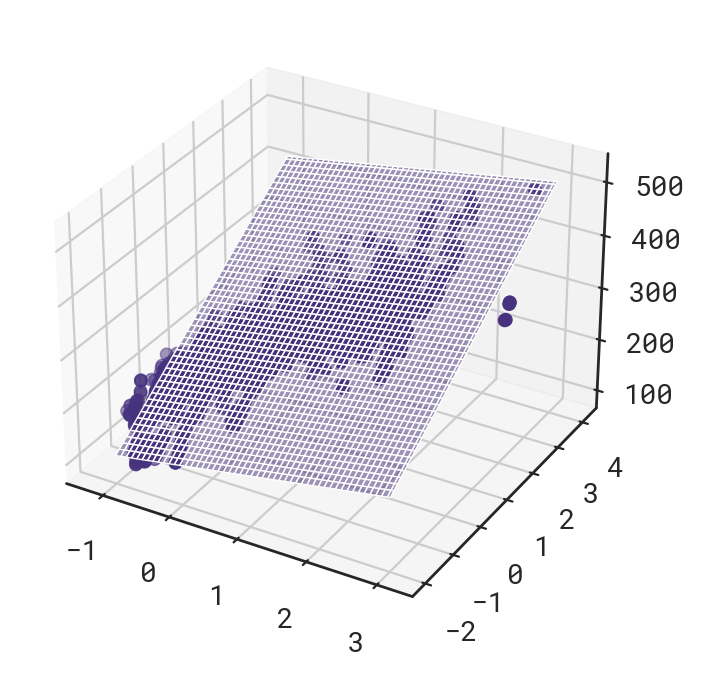

In [42]:
fig = plt.figure(figsize = (5, 4))
ax = plt.axes(projection = '3d')
print(type(ax))

x = np.linspace(-1, 3, 100)
y = np.linspace(-2, 4, 100)
x, y = np.meshgrid(x, y)
eq = lin_reg.weights[0] * x + lin_reg.weights[1] * y + lin_reg.bias
# ax = fig.gca(projection='3d')
ax.plot_surface(x, y, eq, alpha=0.5)

ax.scatter3D(x_train_example[example_features[0]], x_train_example[example_features[1]], y_train_example)

plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objs as go

fig = px.scatter_3d(x_train_example, x=example_features[0], y=example_features[1], z=y_train_example)
fig.update_traces(marker_size=3)

x = np.linspace(-1, 3, 100)
y = np.linspace(-2, 4, 100)
x, y = np.meshgrid(x, y)
Z = lin_reg.weights[0] * x + lin_reg.weights[1] * y + lin_reg.bias
surf = dict(
    type='surface',
    x=x,
    y=y,
    z=Z,
    colorscale='Viridis'
)
fig.add_trace(go.Surface(x=x, y=y, z=Z, colorscale='Viridis'))

fig.show(renderer='iframe')

#### Regression Model's Best-Fit Hyperplane Visualized
![Regression Fit Plane](../images/regression-fit-plane.png)

#### Comments
We can see that when we used two variables to predict the CO2 emissions, Linear (or Multiple Linear) Regression is fitting a line / plane / hyperplane (depending on the number of features), to the data quite well given the distribution of the data.

So, let's try fitting the model to all features.

In [ ]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_train = lin_reg.predict(x_train)
y_pred_test = lin_reg.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
r2_test = metrics.r2_score(y_true=y_test, y_pred=y_pred_test)

print("LinearRegression: \n\tCoefficients: {}, \n\tIntercept: {}".format(lin_reg.coef_, lin_reg.intercept_))
print("MSE: \n\tTrain: \t{}, \n\tTest: \t{}".format(train_mse, test_mse))
print("R2 Score: \n\tTrain: \t{}, \n\tTest: \t{}".format(r2_train, r2_test))

2025/05/04 05:45:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04c92de051834096a6cbb2c3af472024', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/04 05:45:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


LinearRegression: 
Coefficients: [  0.19457534   5.59481107  -3.23224558 ...  11.14831004  12.99363228
 -31.61355551], Intercept: 273.95165716309026
MSE: 
	Train: 	9.391606675837954, 
	Test: 	38.0359678377106
R2 Score: 
	Train: 	0.9973095207006326, 
	Test: 	0.9894599887101561


### 4.1.2 Ridge Regression

In [ ]:
rr = linear_model.Ridge(alpha=0.01)
rr.fit(x_train, y_train)
y_pred_train = rr.predict(x_train)
y_pred_test = rr.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
r2_test = metrics.r2_score(y_true=y_test, y_pred=y_pred_test)

print("Ridge Regression: \n\tCoefficients: {}, \n\tIntercept: {}".format(rr.coef_, rr.intercept_))
print("MSE: \n\tTrain: \t{}, \n\tTest: \t{}".format(train_mse, test_mse))
print("R2 Score: \n\tTrain: \t{}, \n\tTest: \t{}".format(r2_train, r2_test))

2025/05/04 05:49:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '63076be63d814e4dab532a9065552ef0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/04 05:49:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


LinearRegression: 
Coefficients: [  0.17140396   5.42770714  -3.21095062 ...  11.21359283  13.98371199
 -30.49069438], Intercept: 274.01230953203543
MSE: 
	Train: 	9.399863968041169, 
	Test: 	37.323504443174684
R2 Score: 
	Train: 	0.9973071551763396, 
	Test: 	0.9896574168984974


### 4.1.3 Lasso Regression

In [ ]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
y_pred_train = lasso.predict(x_train)
y_pred_test = lasso.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
r2_test = metrics.r2_score(y_true=y_test, y_pred=y_pred_test)

print("Lasso Regression: \n\tCoefficients: {}, \n\tIntercept: {}".format(lasso.coef_, lasso.intercept_))
print("MSE: \n\tTrain: \t{}, \n\tTest: \t{}".format(train_mse, test_mse))
print("R2 Score: \n\tTrain: \t{}, \n\tTest: \t{}".format(r2_train, r2_test))

2025/05/04 05:50:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21fafdfc0efe438fa53f46f162def8c8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/04 05:50:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


LinearRegression: 
Coefficients: [ 0.          0.         -1.08154188 ... 24.48347871  0.799785
 -8.45382154], Intercept: 274.9765300185176
MSE: 
	Train: 	21.979532276669637, 
	Test: 	35.853137335203314
R2 Score: 
	Train: 	0.9937033695467361, 
	Test: 	0.9900648650797651


# 5. Conclusion

We used this dataset to predict CO2 emissions from vehicle information, but we could have used it to analyze fuel efficiency or just to visualize fuel efficiency by various categories. Sometimes data analysis is enough to provide key insights and drive business/policy decisions.